In [2]:
from utils import *

import os
import sys
sys.path.append(os.path.join(os.getcwd()))

import pickle
from torch import tensor
import torch
from torch.utils.data import DataLoader


from src.model.dataset import MaskRCNNDataset
from src.model.model import maskRCNNModel
from src.model.engine import FitterMaskRCNN


/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
weigts_dir = "/Volumes/Extreme_SSD/Gastrointestinal_voucher/weights/multirater"
# weigts_dir = "/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/weights"
multi_1_dir = os.path.join(weigts_dir, "1", )
multi_2_dir = os.path.join(weigts_dir, "2")
multi_all_dir = os.path.join(weigts_dir, "all")

test_dataset_path = "../dataset/test_multirater_consensus"
test_dataset = MaskRCNNDataset(dataset_path=test_dataset_path, datatype="eval", data_augmentation=None)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# dataset containing predictions from two different annotators
test_dataset_multi_path = "../dataset/test_multirater"
test_dataset_multi_1 = MaskRCNNDataset(dataset_path=test_dataset_multi_path, datatype="eval", data_augmentation=None, annotator=1)
test_dataset_multi_2 = MaskRCNNDataset(dataset_path=test_dataset_multi_path, datatype="eval", data_augmentation=None, annotator=2)
# Create target list
target = []
for _, t in test_dataset:
    del t["masks"]
    target.append(t)

# TODO choose the actual best models
best_10_1 = [28, 68, 37, 27, 72, 33, 74, 56, 57, 43]
# best_10_2 = [21, 66, 67, 64, 73, 65, 76, 26, 18, 58]
best_10_2 = [65, 22, 49, 51, 70, 47, 64, 21, 54, 56]
best_10_all = [14, 74, 16, 75, 55, 18, 65, 33, 66, 30]

fitter = FitterMaskRCNN() 



/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [4]:
def predict(model: maskRCNNModel, dataloader: DataLoader, fitter: FitterMaskRCNN):
    predictions, metric = fitter.evaluate_one_epoch_predictions(model, dataloader, confidence_threshold=0)
    for i, pred in enumerate(predictions):
        del pred["masks"]
    return predictions, metric

def predict_ensamble(weigts_dir: str, models_id: list, dataloader: DataLoader, fitter: FitterMaskRCNN):
    all_predictions = {}
    all_metrics = {}
    for i, model_id in enumerate(models_id):
        model_path = os.path.join(weigts_dir, f"best-checkpoint-{model_id}.bin")
        model = maskRCNNModel()
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['model_state_dict'])
        predictions, metric= predict(model, dataloader, fitter)
        all_predictions[i] = predictions
        all_metrics[i] = metric

    return all_predictions, all_metrics

# store the predictions
path = "multirater_predictions"
os.makedirs(path, exist_ok=True)
if not os.path.exists(os.path.join(path, "predictions_1.pkl")):
    predictions_1, metrics_1 = predict_ensamble(multi_1_dir, best_10_1, test_loader, fitter)
    print(predictions_1.keys())
    with open(os.path.join(path, "predictions_1.pkl"), "wb") as f:
        pickle.dump(predictions_1, f)
    with open(os.path.join(path, "metrics_1.pkl"), "wb") as f:
        pickle.dump(metrics_1, f)
else:
    predictions_1 = pickle.load(open(os.path.join(path, "predictions_1.pkl"), "rb"))
    metrics_1 = pickle.load(open(os.path.join(path, "metrics_1.pkl"), "rb"))

if not os.path.exists(os.path.join(path, "predictions_2.pkl")):
    predictions_2, metrics_2 = predict_ensamble(multi_2_dir, best_10_2, test_loader, fitter)
    with open(os.path.join(path, "predictions_2.pkl"), "wb") as f:
        pickle.dump(predictions_2, f)
    with open(os.path.join(path, "metrics_2.pkl"), "wb") as f:
        pickle.dump(metrics_2, f)
else:
    predictions_2 = pickle.load(open(os.path.join(path, "predictions_2.pkl"), "rb"))
    metrics_2 = pickle.load(open(os.path.join(path, "metrics_2.pkl"), "rb"))

if not os.path.exists(os.path.join(path, "predictions_all.pkl")):
    predictions_all, metrics_all = predict_ensamble(multi_all_dir, best_10_all, test_loader, fitter)
    with open(os.path.join(path, "predictions_all.pkl"), "wb") as f:
        pickle.dump(predictions_all, f)
    with open(os.path.join(path, "metrics_all.pkl"), "wb") as f:
        pickle.dump(metrics_all, f)
else:
    predictions_all = pickle.load(open(os.path.join(path, "predictions_all.pkl"), "rb"))
    metrics_all = pickle.load(open(os.path.join(path, "metrics_all.pkl"), "rb"))

print(type(predictions_all[0][0]["boxes"]))


<class 'torch.Tensor'>


# Calibration error of single models

In [4]:
matched_pred_1 = {}
for id, pred in predictions_1.items():
    matched_pred_1[id] = match_predictions(pred, test_dataset, iou_threshold=0.5)
matched_pred_1_single = {}
for id, pred in predictions_1.items():
    matched_pred_1_single[id] = match_predictions(pred, test_dataset_multi_1, iou_threshold=0.5)
matched_pred_2 = {}
for id, pred in predictions_2.items():
    matched_pred_2[id] = match_predictions(pred, test_dataset, iou_threshold=0.5)
matched_pred_2_single = {}
for id, pred in predictions_2.items():
    matched_pred_2_single[id] = match_predictions(pred, test_dataset_multi_2, iou_threshold=0.5)
matched_pred_all = {}
for id, pred in predictions_all.items():
    matched_pred_all[id] = match_predictions(pred, test_dataset, iou_threshold=0.5)
bins_extremes=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = list(range(len(bins_extremes) - 1))
print(type(predictions_all[0][0]["boxes"]))

20it [00:02,  6.95it/s]
20it [00:02,  8.26it/s]
20it [00:02,  8.13it/s]
20it [00:02,  7.66it/s]
20it [00:02,  7.49it/s]
20it [00:02,  7.99it/s]
20it [00:02,  7.11it/s]
20it [00:02,  7.69it/s]
20it [00:02,  7.84it/s]
20it [00:02,  7.87it/s]
20it [00:02,  9.28it/s]
20it [00:01, 10.58it/s]
20it [00:01, 10.68it/s]
20it [00:01, 11.17it/s]
20it [00:01, 10.59it/s]
20it [00:01, 10.60it/s]
20it [00:01, 10.82it/s]
20it [00:01, 10.48it/s]
20it [00:01, 10.55it/s]
20it [00:01, 10.72it/s]
20it [00:02,  6.74it/s]
20it [00:02,  8.09it/s]
20it [00:02,  8.09it/s]
20it [00:02,  8.04it/s]
20it [00:02,  8.04it/s]
20it [00:02,  8.12it/s]
20it [00:02,  8.11it/s]
20it [00:02,  7.96it/s]
20it [00:02,  7.71it/s]
20it [00:02,  7.84it/s]
20it [00:02,  7.37it/s]
20it [00:02,  7.93it/s]
20it [00:02,  7.75it/s]
20it [00:02,  7.87it/s]
20it [00:02,  7.79it/s]
20it [00:02,  7.90it/s]
20it [00:02,  7.67it/s]
20it [00:02,  7.95it/s]
20it [00:02,  7.79it/s]
20it [00:02,  7.48it/s]
20it [00:03,  5.48it/s]
20it [00:03,  6.

<class 'torch.Tensor'>


Annotator 1
0


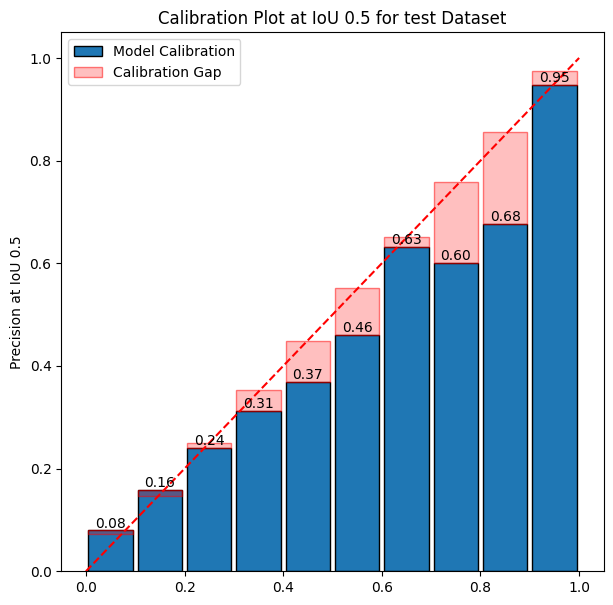

Calibration Error at IoU 0.5: 0.05
Model 0 Calibration Error: 0.05
1


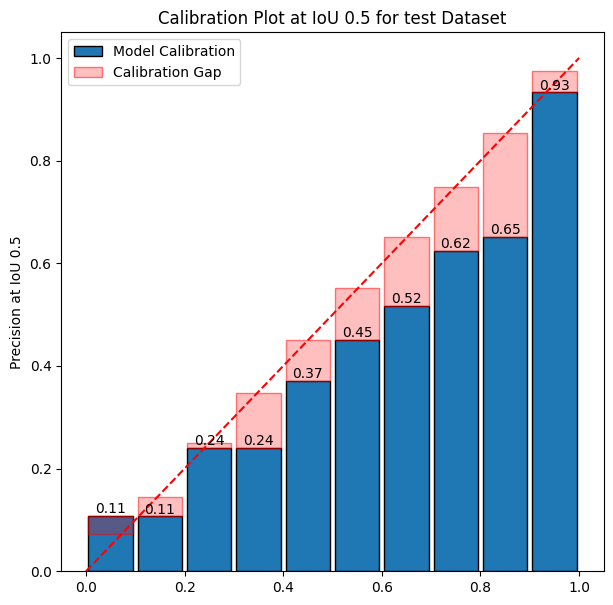

Calibration Error at IoU 0.5: 0.07
Model 1 Calibration Error: 0.07
2


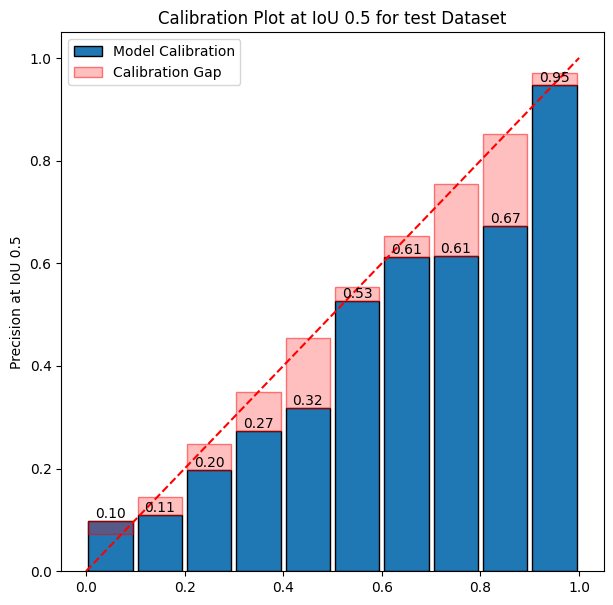

Calibration Error at IoU 0.5: 0.06
Model 2 Calibration Error: 0.06
3


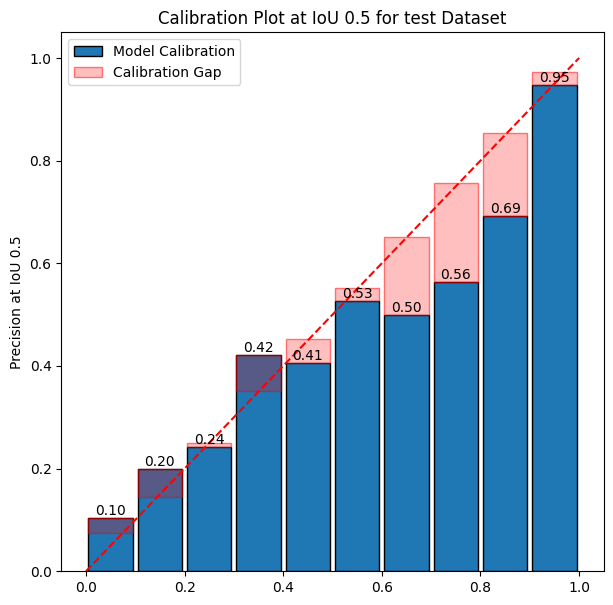

Calibration Error at IoU 0.5: 0.06
Model 3 Calibration Error: 0.06
4


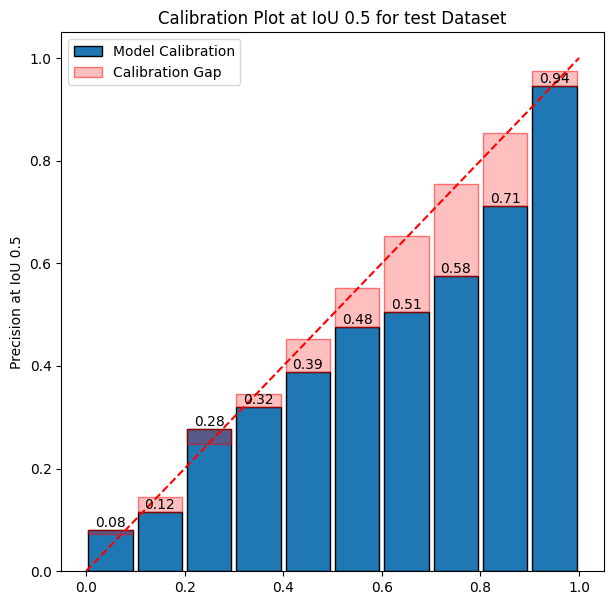

Calibration Error at IoU 0.5: 0.06
Model 4 Calibration Error: 0.06
5


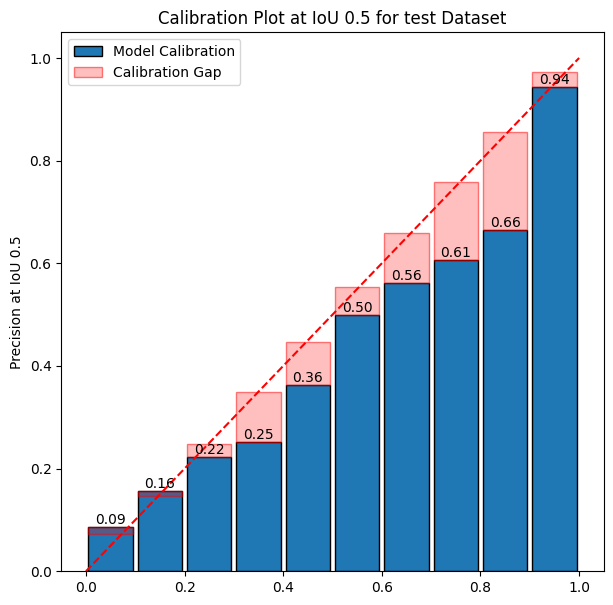

Calibration Error at IoU 0.5: 0.06
Model 5 Calibration Error: 0.06
6


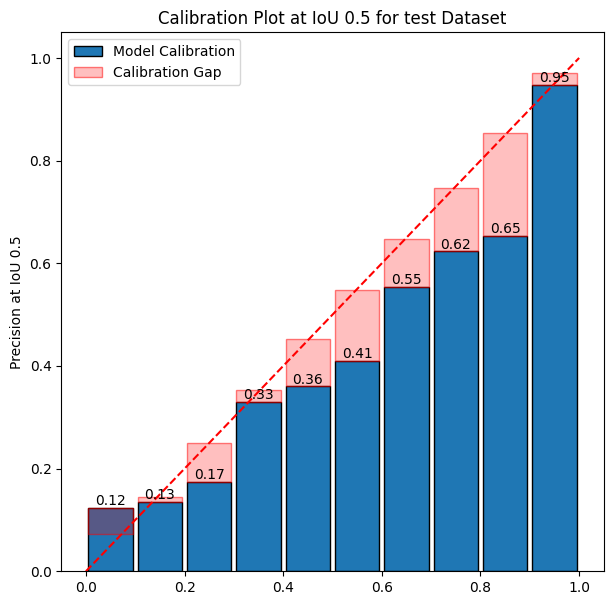

Calibration Error at IoU 0.5: 0.07
Model 6 Calibration Error: 0.07
7


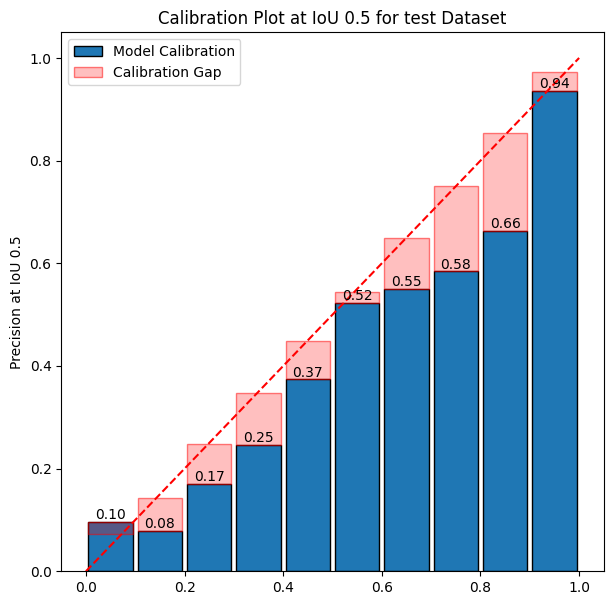

Calibration Error at IoU 0.5: 0.07
Model 7 Calibration Error: 0.07
8


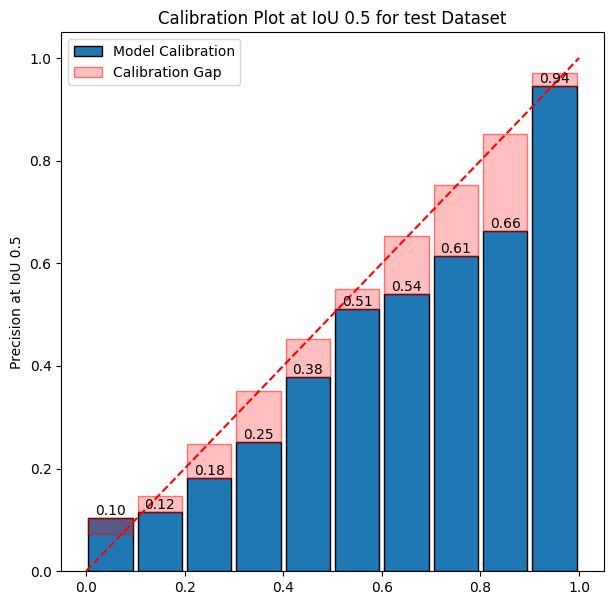

Calibration Error at IoU 0.5: 0.07
Model 8 Calibration Error: 0.07
9


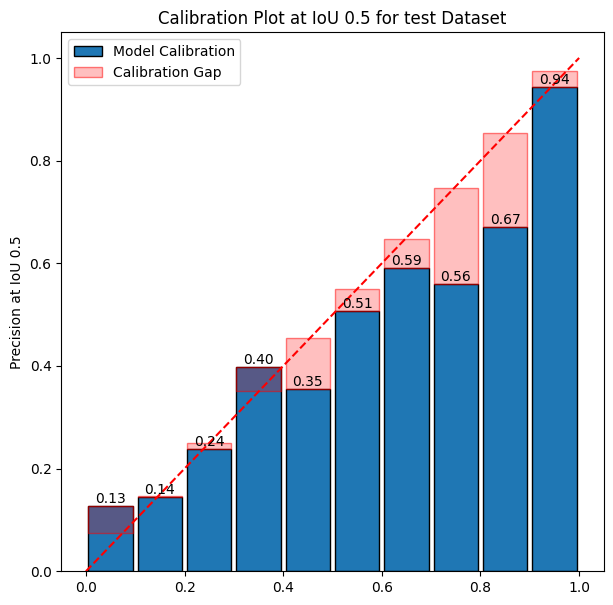

Calibration Error at IoU 0.5: 0.06
Model 9 Calibration Error: 0.06

Annotator 2


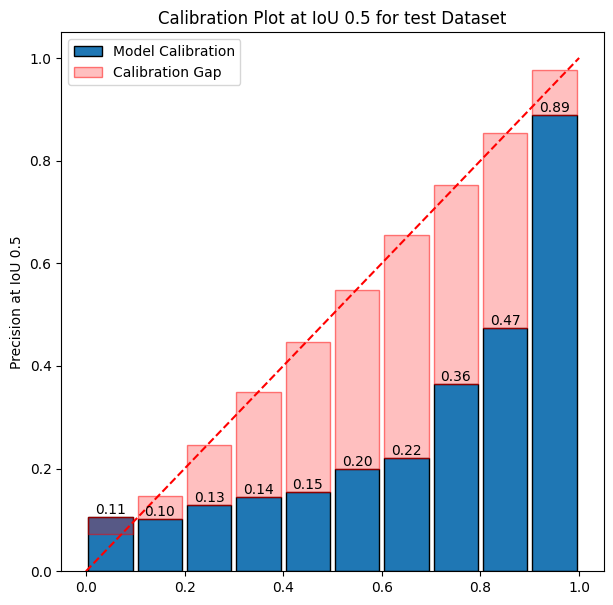

Calibration Error at IoU 0.5: 0.18
Model 0 Calibration Error: 0.18


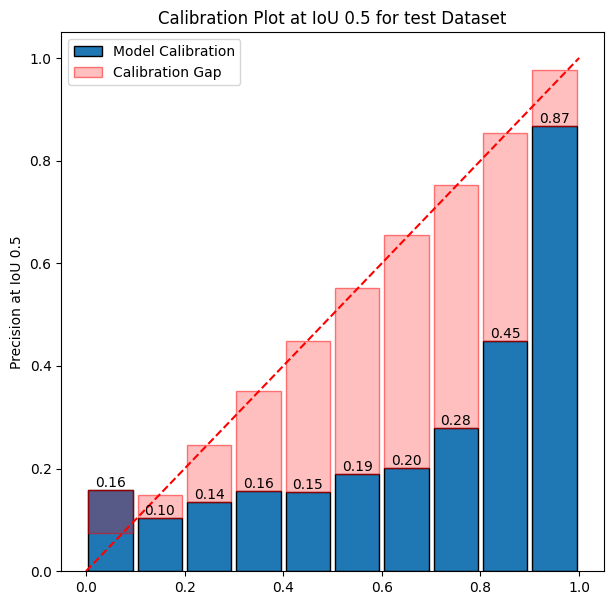

Calibration Error at IoU 0.5: 0.20
Model 1 Calibration Error: 0.20


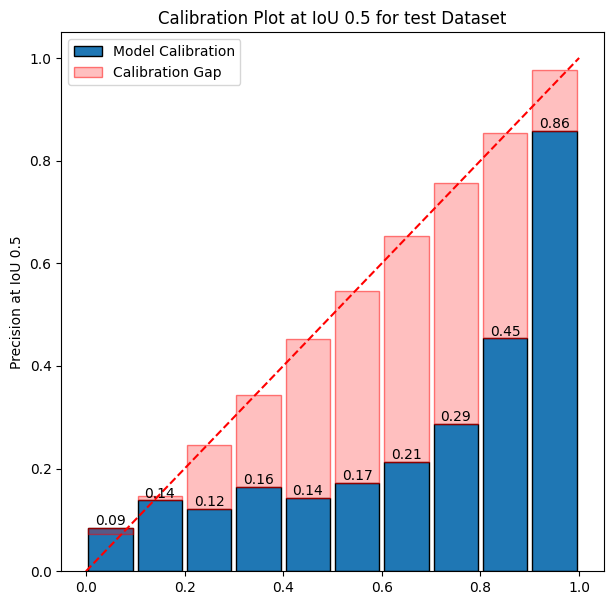

Calibration Error at IoU 0.5: 0.19
Model 2 Calibration Error: 0.19


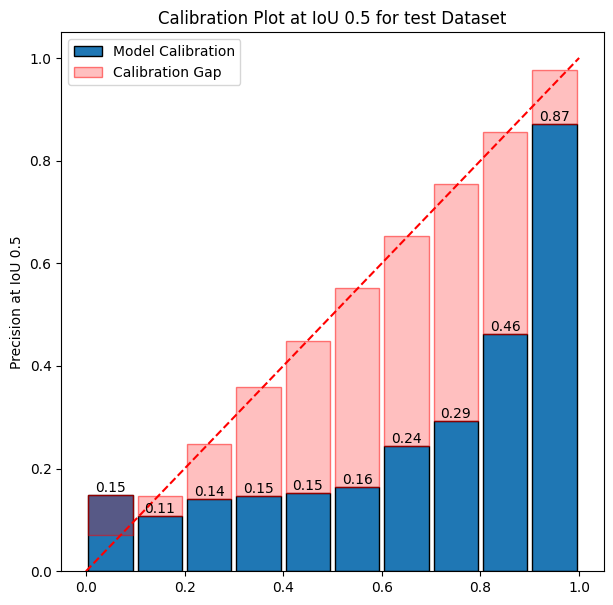

Calibration Error at IoU 0.5: 0.20
Model 3 Calibration Error: 0.20


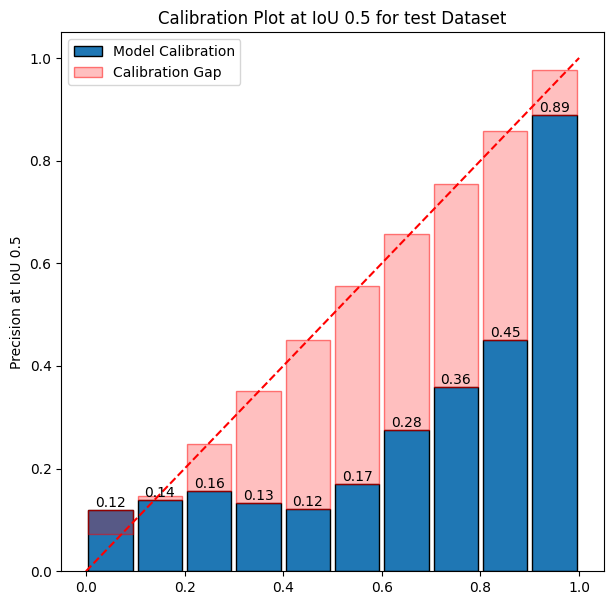

Calibration Error at IoU 0.5: 0.18
Model 4 Calibration Error: 0.18


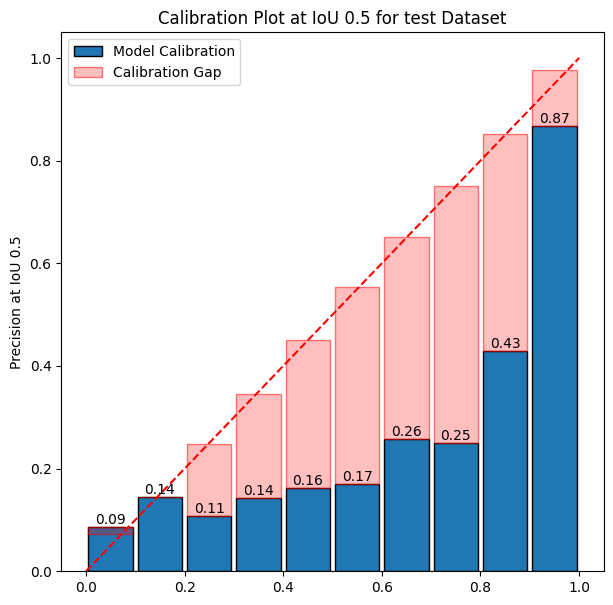

Calibration Error at IoU 0.5: 0.20
Model 5 Calibration Error: 0.20


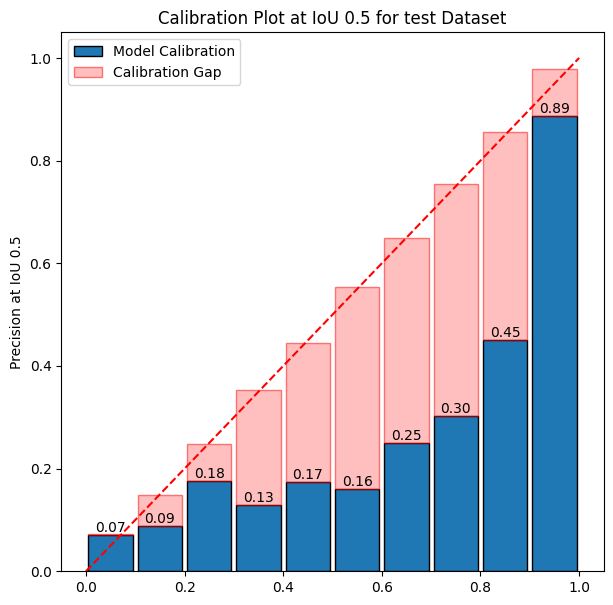

Calibration Error at IoU 0.5: 0.18
Model 6 Calibration Error: 0.18


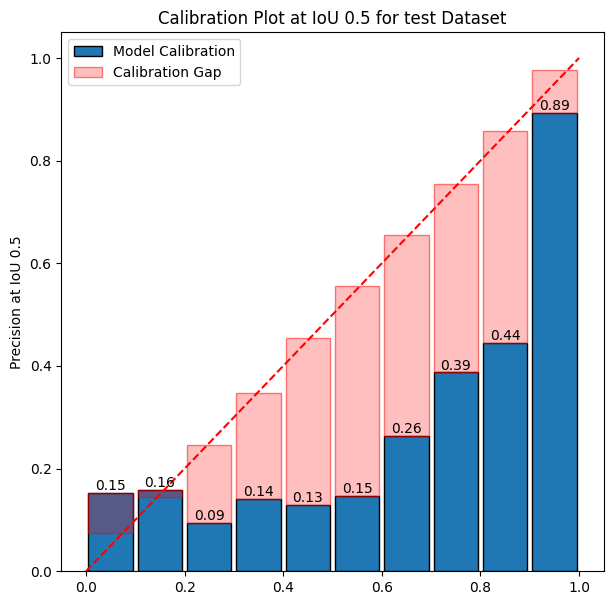

Calibration Error at IoU 0.5: 0.19
Model 7 Calibration Error: 0.19


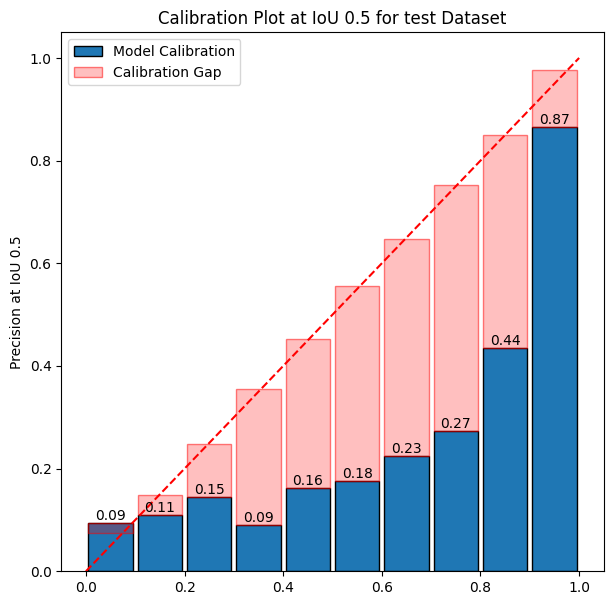

Calibration Error at IoU 0.5: 0.20
Model 8 Calibration Error: 0.20


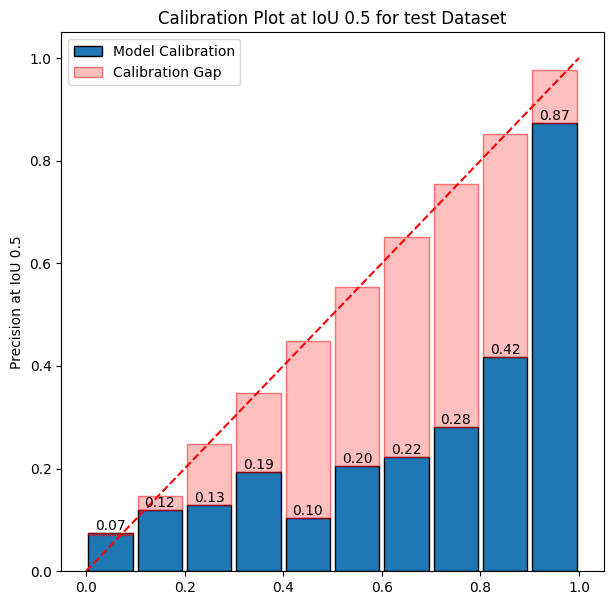

Calibration Error at IoU 0.5: 0.20
Model 9 Calibration Error: 0.20

Both annotators


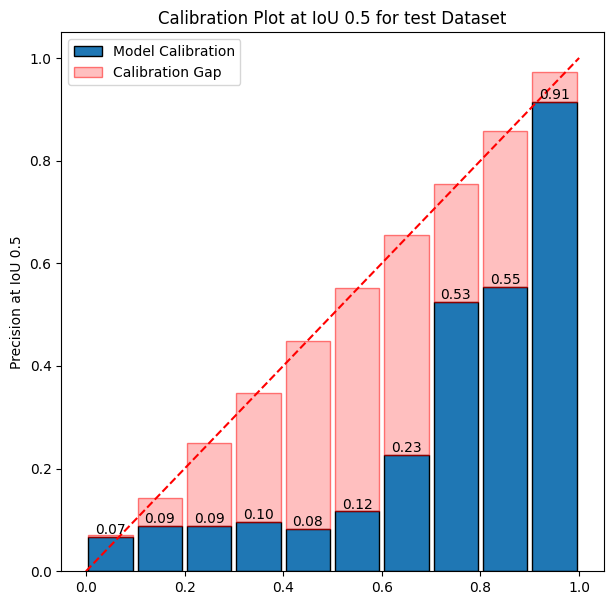

Calibration Error at IoU 0.5: 0.17
Model 0 Calibration Error: 0.17


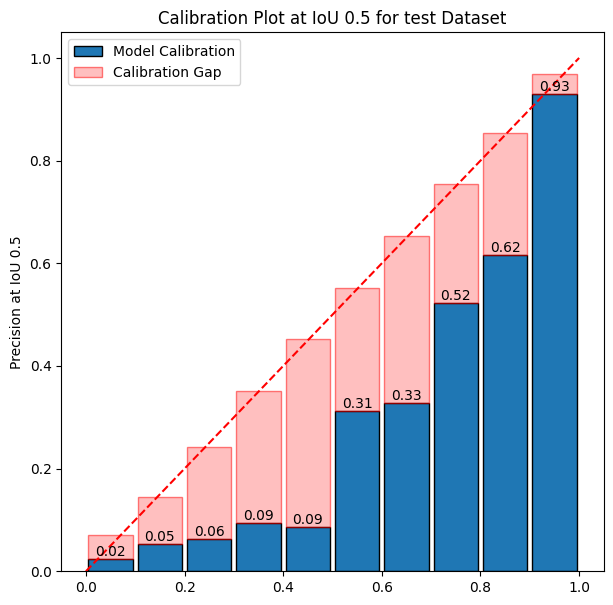

Calibration Error at IoU 0.5: 0.15
Model 1 Calibration Error: 0.15


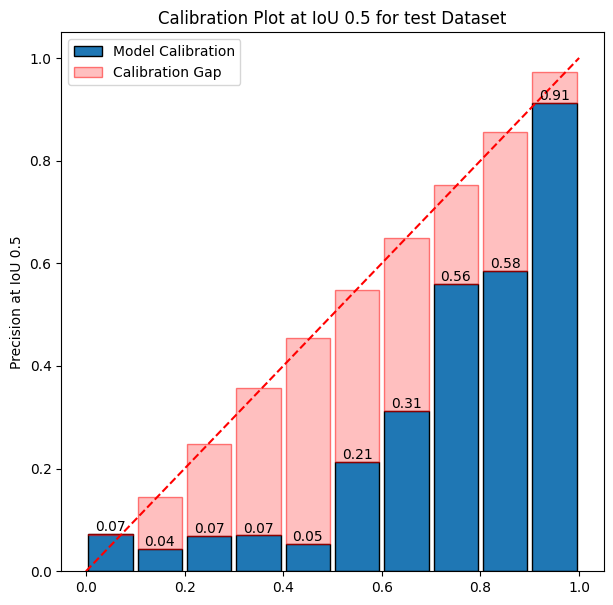

Calibration Error at IoU 0.5: 0.16
Model 2 Calibration Error: 0.16


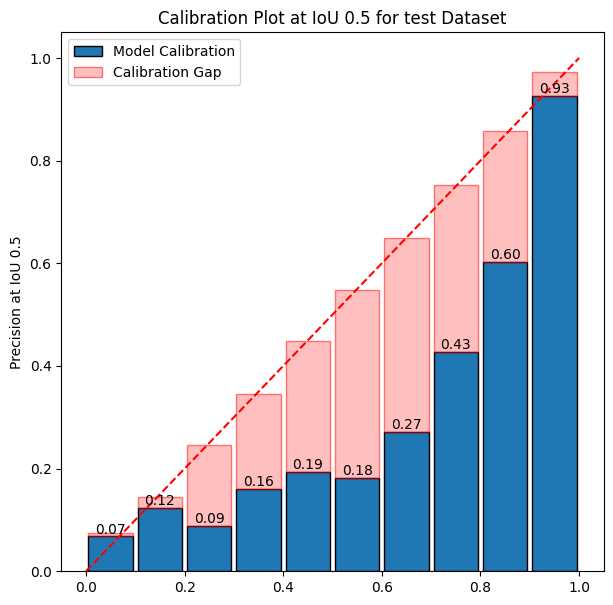

Calibration Error at IoU 0.5: 0.16
Model 3 Calibration Error: 0.16


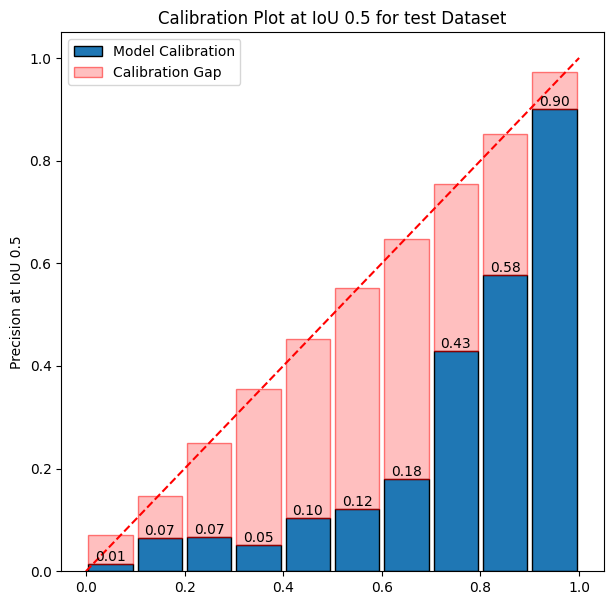

Calibration Error at IoU 0.5: 0.18
Model 4 Calibration Error: 0.18


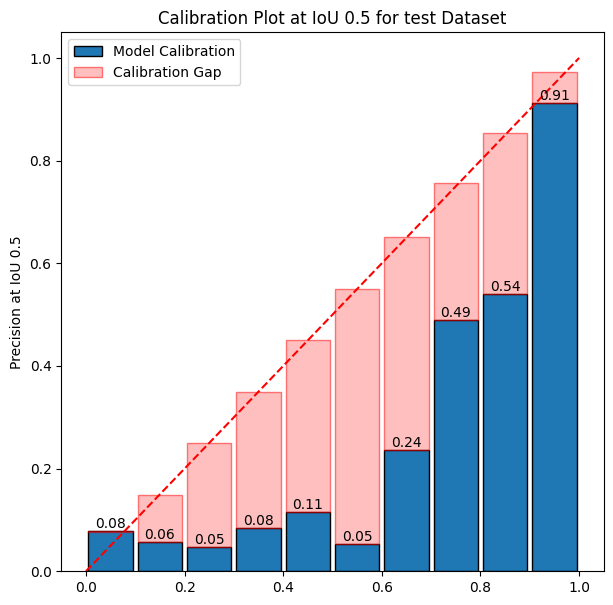

Calibration Error at IoU 0.5: 0.18
Model 5 Calibration Error: 0.18


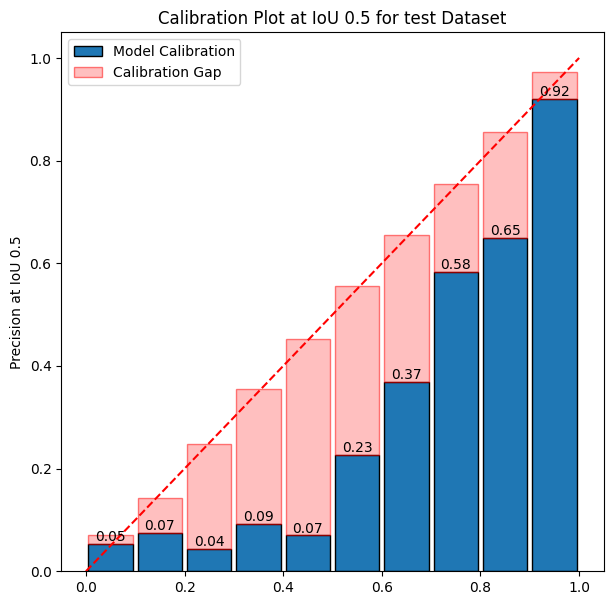

Calibration Error at IoU 0.5: 0.14
Model 6 Calibration Error: 0.14


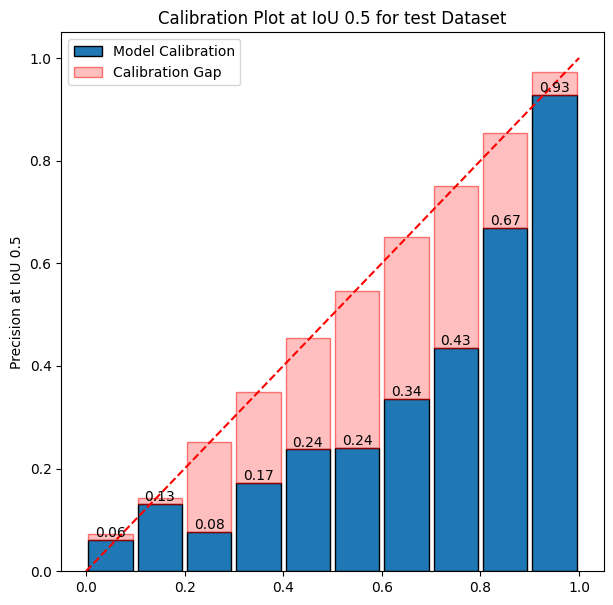

Calibration Error at IoU 0.5: 0.14
Model 7 Calibration Error: 0.14


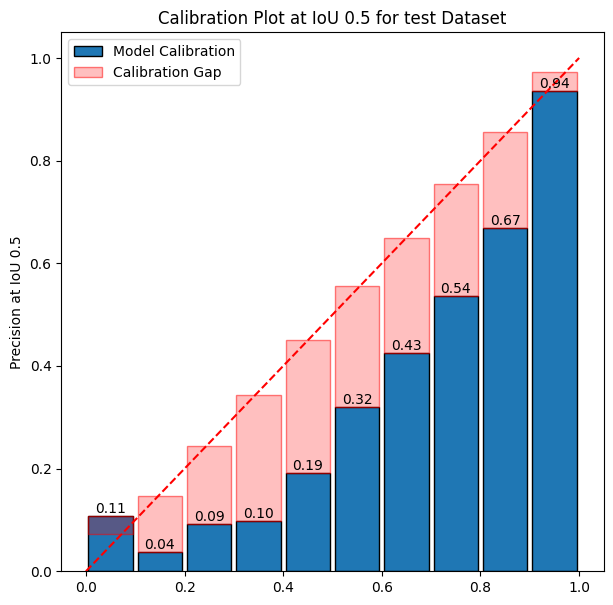

Calibration Error at IoU 0.5: 0.12
Model 8 Calibration Error: 0.12


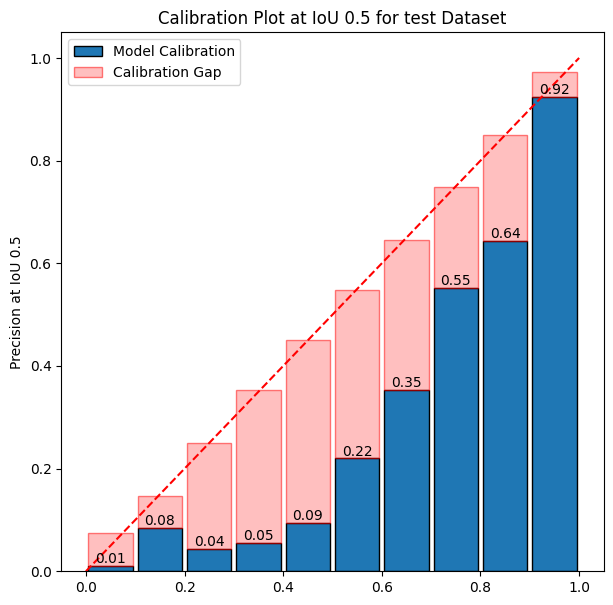

Calibration Error at IoU 0.5: 0.14
Model 9 Calibration Error: 0.14
annotator 1 [0.050368405432651225, 0.07166220874226696, 0.05993770031214592, 0.06093058573428764, 0.056439514063565406, 0.059772160497596455, 0.06583670951242601, 0.07375422413016079, 0.06627441228863722, 0.058294117372620226] mean: 0.06232700380863578, std: 0.0067360837722496136
annotator 2 [0.1830126015113324, 0.20346322574857267, 0.19468995610299378, 0.19730506959145125, 0.18309003964693335, 0.19642092581236303, 0.1835348914550868, 0.18832865731116302, 0.20130778057129678, 0.19650752894099083] mean: 0.1927660676692184, std: 0.007298707428646237
both annotators [0.16919496329339506, 0.14698365967364577, 0.15932949870405694, 0.15818786539643426, 0.1835519116763328, 0.1751540545383841, 0.13955869627976888, 0.13664054044910204, 0.12186678048154644, 0.14360052416275249] mean: 0.1534068494655419, std: 0.01814922568321115


In [5]:
calibration_errors_1 = []
print("Annotator 1")
for id, pred in matched_pred_1.items():
    print(id)
    ce = plot_calibration(detections=pred, dataset="test", iou=0.5, bins_extremes=bins_extremes, labels=labels)
    print(f"Model {id} Calibration Error: {ce:.2f}")
    calibration_errors_1.append(ce)

calibration_errors_2 = []
print("\nAnnotator 2")
for id, pred in matched_pred_2.items():
    ce = plot_calibration(detections=pred, dataset="test", iou=0.5, bins_extremes=bins_extremes, labels=labels)
    print(f"Model {id} Calibration Error: {ce:.2f}")
    calibration_errors_2.append(ce)

calibration_errors_all = []
print("\nBoth annotators")
for id, pred in matched_pred_all.items():
    ce = plot_calibration(detections=pred, dataset="test", iou=0.5, bins_extremes=bins_extremes, labels=labels)
    print(f"Model {id} Calibration Error: {ce:.2f}")
    calibration_errors_all.append(ce)

print("annotator 1", calibration_errors_1, f"mean: {np.mean(calibration_errors_1)}, std: {np.std(calibration_errors_1)}")
print("annotator 2", calibration_errors_2, f"mean: {np.mean(calibration_errors_2)}, std: {np.std(calibration_errors_2)}")
print("both annotators", calibration_errors_all, f"mean: {np.mean(calibration_errors_all)}, std: {np.std(calibration_errors_all)}")

In [6]:
metric = pd.DataFrame(columns=["Annotator", "ID", "MAP", "MAR"])
for id, m in metrics_1.items():
    metric.loc[len(metric)] = {"Annotator": 1, "ID": id, "MAP": m["map"].item(), "MAR": m["mar_100"].item()}
for id, m in metrics_2.items():
    metric.loc[len(metric)] = {"Annotator": 2, "ID": id, "MAP": m["map"].item(), "MAR": m["mar_100"].item()}
for id, m in metrics_all.items():
    metric.loc[len(metric)] = {"Annotator": "All", "ID": id, "MAP": m["map"].item(), "MAR": m["mar_100"].item()}
display(metric)

,Annotator,ID,MAP,MAR
0,1,0,0.442709,0.503734
1,1,1,0.443871,0.505506
2,1,2,0.447759,0.509937
3,1,3,0.441547,0.500190
4,1,4,0.446181,0.506456
5,1,5,0.444308,0.506076
6,1,6,0.445244,0.505570
7,1,7,0.442986,0.503291
8,1,8,0.444148,0.505190
9,1,9,0.447342,0.506772



Next, we test the calibration of the models if the gt was the dataset where only a single annotator was taken into consideration. We want to evaluate if the model looses calibration if the test labels belong to the same distribution as the training set

Annotator 1
0


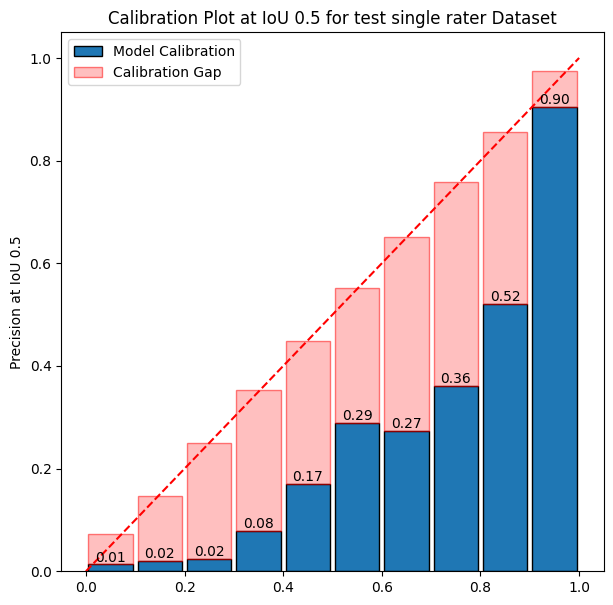

Calibration Error at IoU 0.5: 0.17
Model 0 Calibration Error: 0.17
1


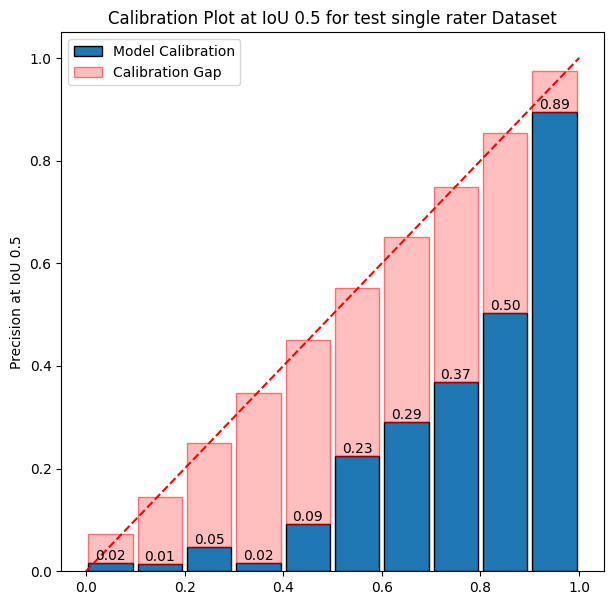

Calibration Error at IoU 0.5: 0.19
Model 1 Calibration Error: 0.19
2


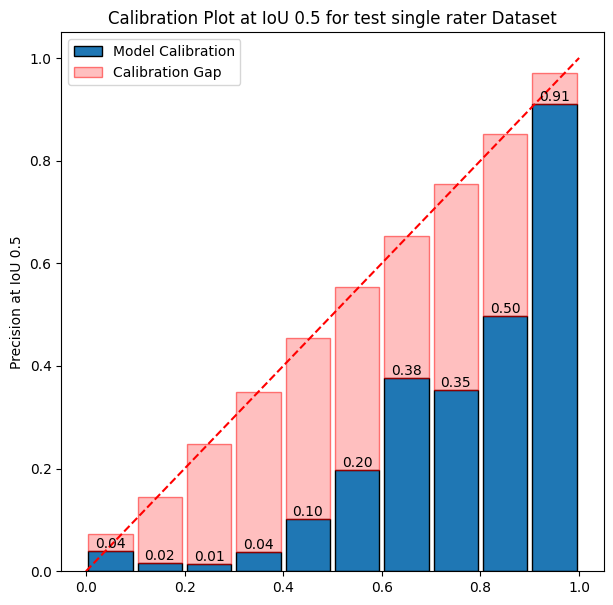

Calibration Error at IoU 0.5: 0.18
Model 2 Calibration Error: 0.18
3


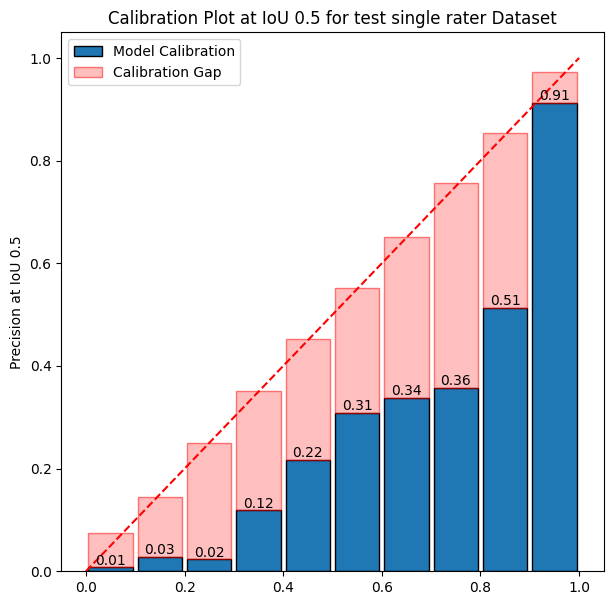

Calibration Error at IoU 0.5: 0.16
Model 3 Calibration Error: 0.16
4


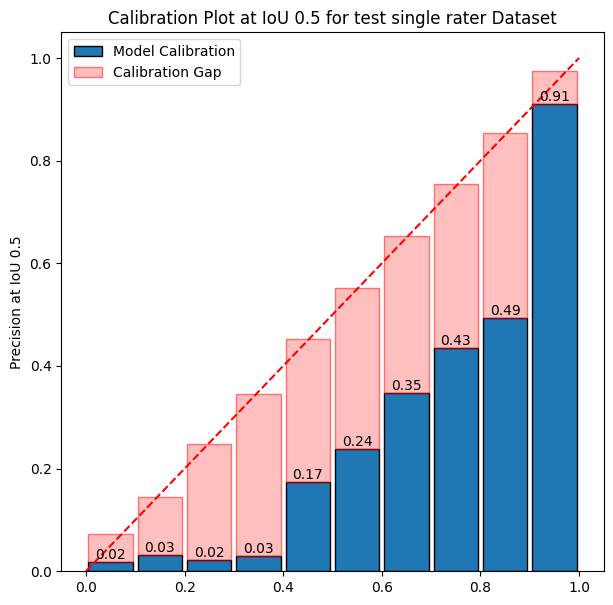

Calibration Error at IoU 0.5: 0.17
Model 4 Calibration Error: 0.17
5


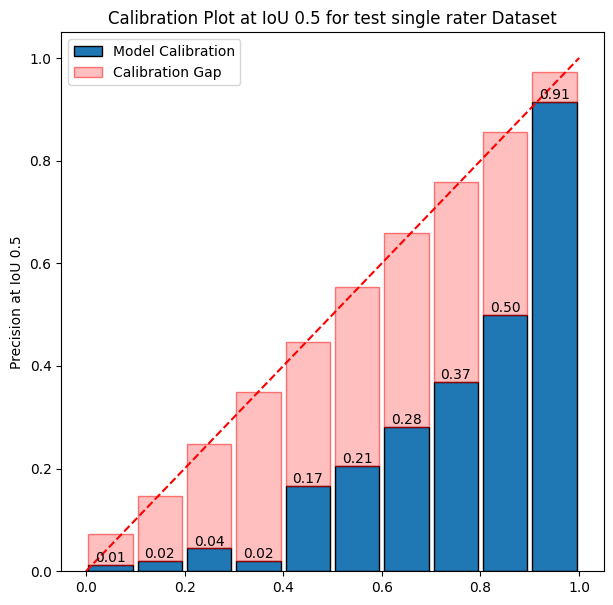

Calibration Error at IoU 0.5: 0.18
Model 5 Calibration Error: 0.18
6


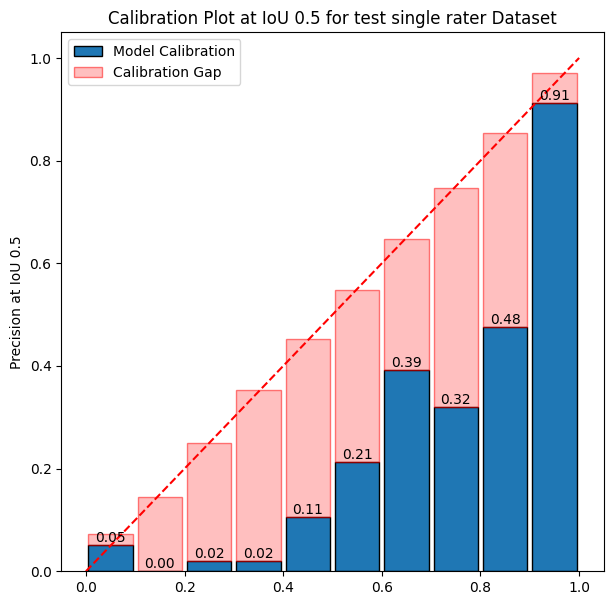

Calibration Error at IoU 0.5: 0.18
Model 6 Calibration Error: 0.18
7


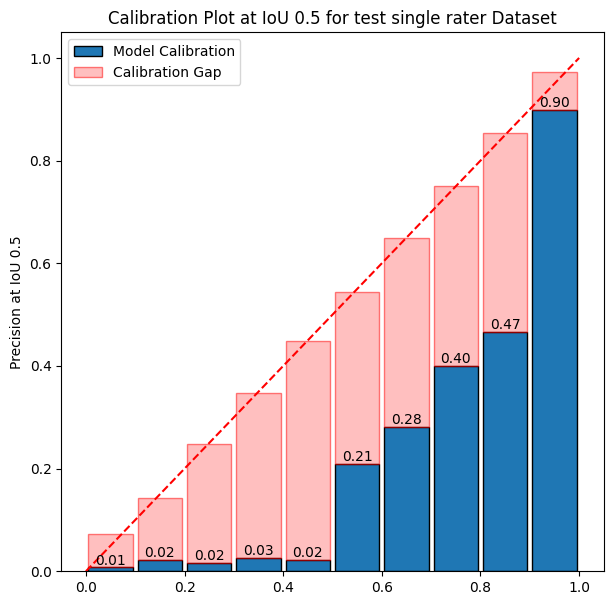

Calibration Error at IoU 0.5: 0.20
Model 7 Calibration Error: 0.20
8


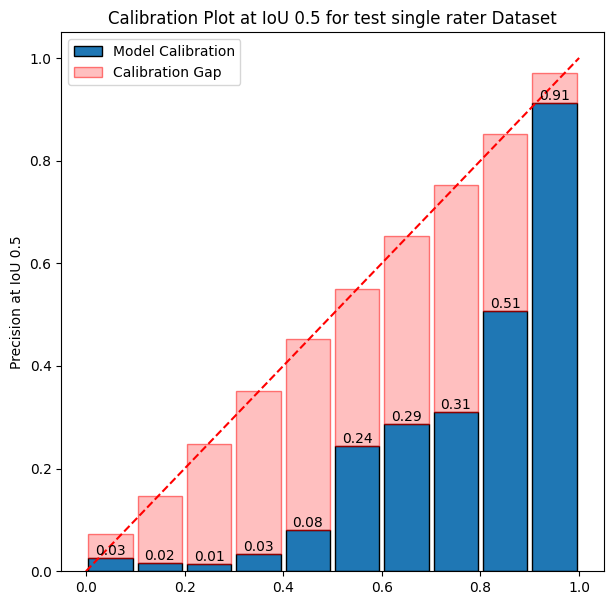

Calibration Error at IoU 0.5: 0.19
Model 8 Calibration Error: 0.19
9


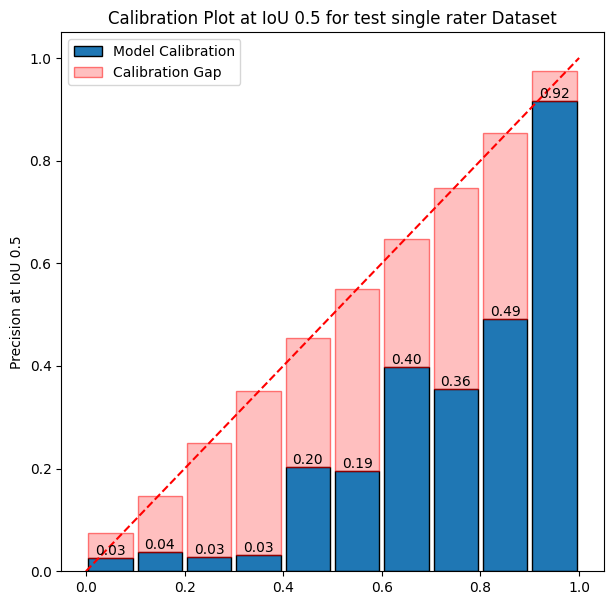

Calibration Error at IoU 0.5: 0.17
Model 9 Calibration Error: 0.17

Annotator 2


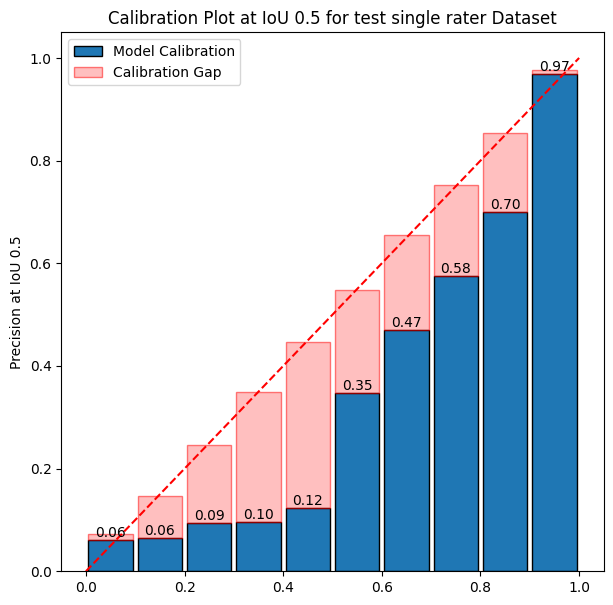

Calibration Error at IoU 0.5: 0.09
Model 0 Calibration Error: 0.09


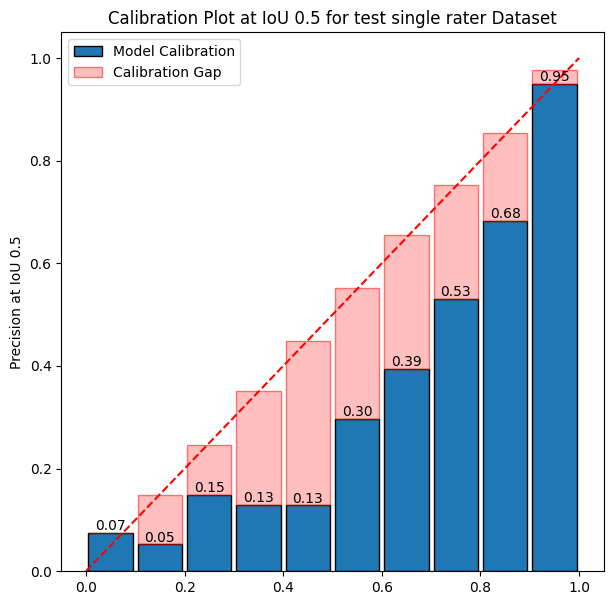

Calibration Error at IoU 0.5: 0.11
Model 1 Calibration Error: 0.11


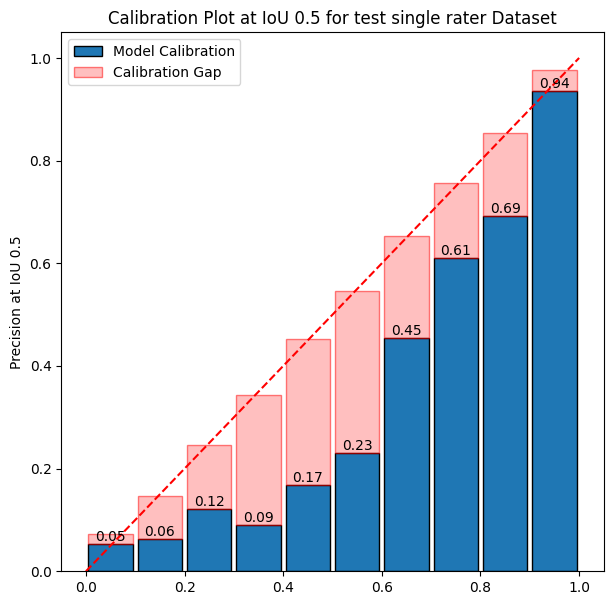

Calibration Error at IoU 0.5: 0.10
Model 2 Calibration Error: 0.10


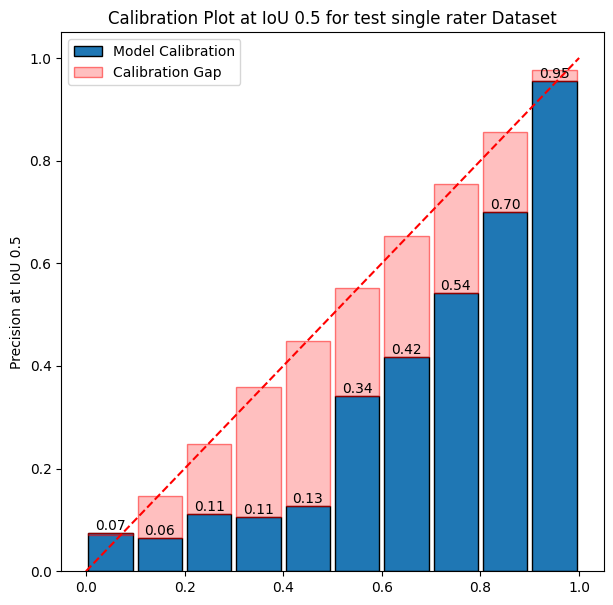

Calibration Error at IoU 0.5: 0.10
Model 3 Calibration Error: 0.10


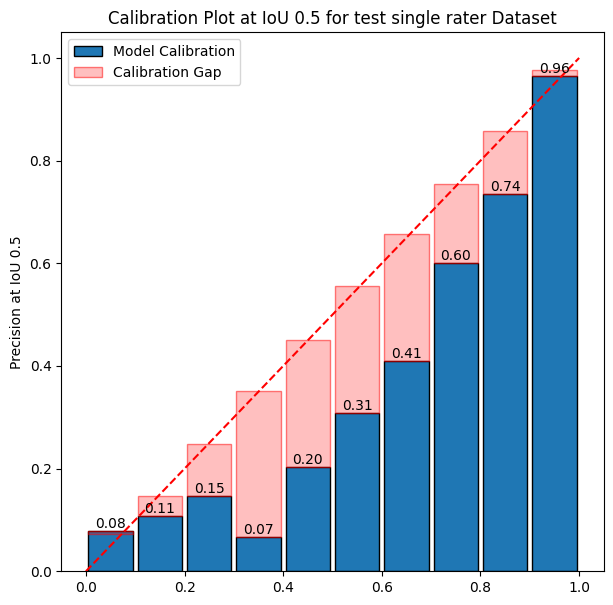

Calibration Error at IoU 0.5: 0.09
Model 4 Calibration Error: 0.09


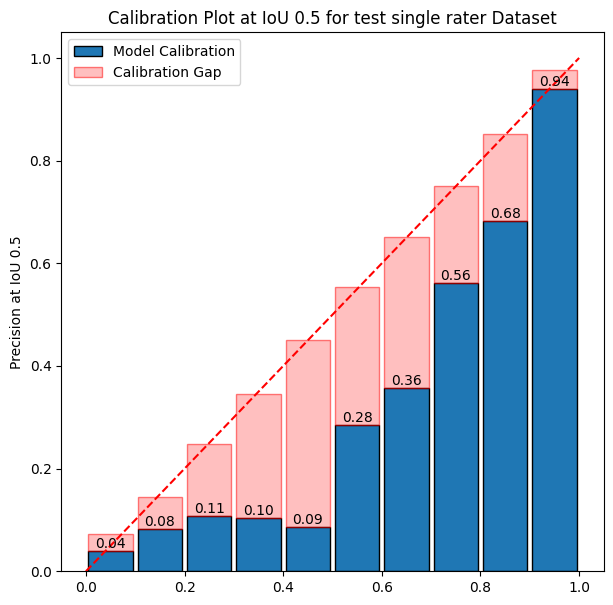

Calibration Error at IoU 0.5: 0.11
Model 5 Calibration Error: 0.11


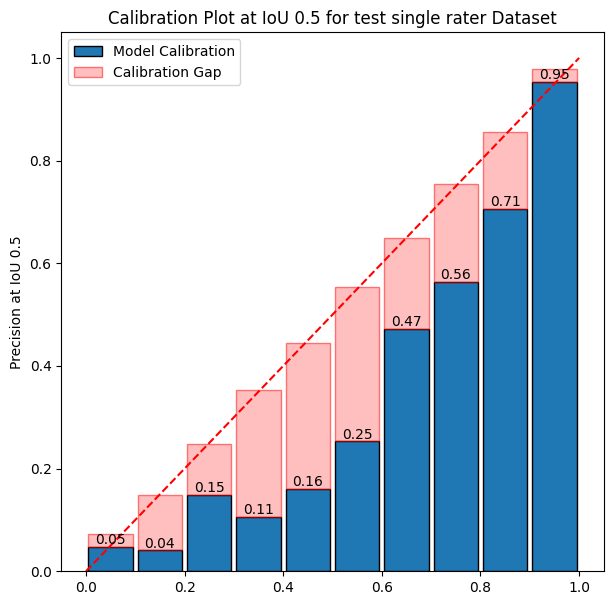

Calibration Error at IoU 0.5: 0.10
Model 6 Calibration Error: 0.10


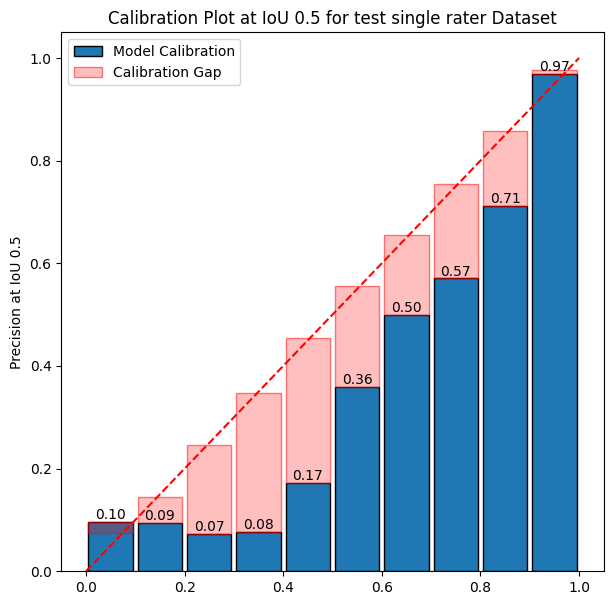

Calibration Error at IoU 0.5: 0.09
Model 7 Calibration Error: 0.09


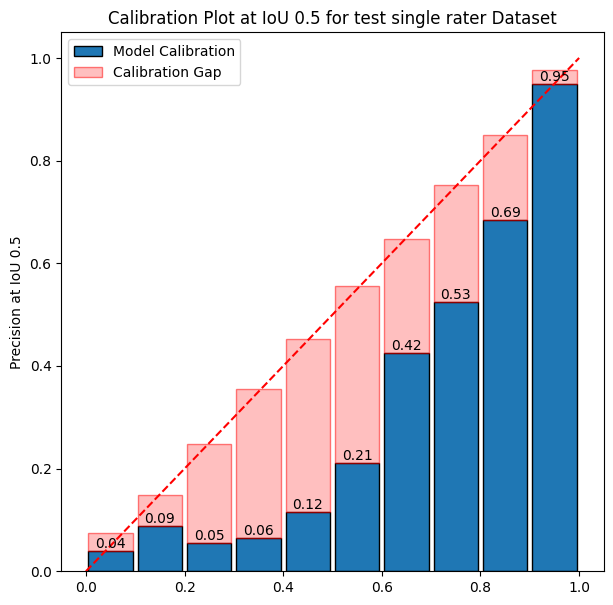

Calibration Error at IoU 0.5: 0.12
Model 8 Calibration Error: 0.12


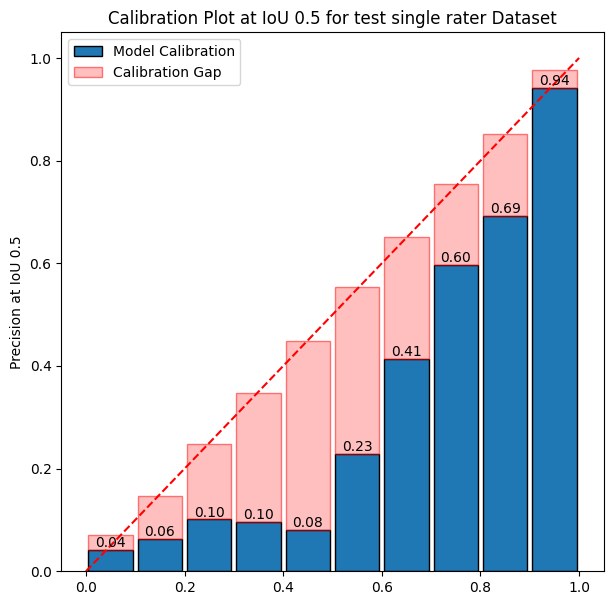

Calibration Error at IoU 0.5: 0.11
Model 9 Calibration Error: 0.11
annotator 1 single rater [0.17325294204715216, 0.19084593571070335, 0.1825930607311699, 0.159343938830335, 0.17348259650545836, 0.1807032429950121, 0.18475545140077193, 0.19828820356935642, 0.19064785294319925, 0.17102921407764762] mean: 0.18049424388108062, std: 0.010899572232547075
annotator 2 single rater [0.09401591175805295, 0.1053822022944149, 0.10394184822926962, 0.10122151867761317, 0.08617843155321663, 0.11431697110899472, 0.10024362441823677, 0.0893203015877394, 0.11659238314760692, 0.11353499160470462] mean: 0.10247481843798496, std: 0.009945804790529467


In [7]:
calibration_errors_1_single = []
print("Annotator 1")
for id, pred in matched_pred_1_single.items():
    print(id)
    ce = plot_calibration(detections=pred, dataset="test single rater", iou=0.5, bins_extremes=bins_extremes, labels=labels)
    print(f"Model {id} Calibration Error: {ce:.2f}")
    calibration_errors_1_single.append(ce)

calibration_errors_2_single = []
print("\nAnnotator 2")
for id, pred in matched_pred_2_single.items():
    ce = plot_calibration(detections=pred, dataset="test single rater", iou=0.5, bins_extremes=bins_extremes, labels=labels)
    print(f"Model {id} Calibration Error: {ce:.2f}")
    calibration_errors_2_single.append(ce)

print("annotator 1 single rater", calibration_errors_1_single, f"mean: {np.mean(calibration_errors_1_single)}, std: {np.std(calibration_errors_1_single)}")
print("annotator 2 single rater", calibration_errors_2_single, f"mean: {np.mean(calibration_errors_2_single)}, std: {np.std(calibration_errors_2_single)}")


In [8]:
# compute the MAP on the single rater datasets
from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric_single = pd.DataFrame(columns=["Annotator", "ID", "MAP", "MAR"])
for id, pred in predictions_1.items():
    map_metric = MeanAveragePrecision(iou_type="bbox")
    for p, t in zip(pred, test_dataset_multi_1):
        map_metric.update([p], [t[1]])
    m = map_metric.compute()
    metric_single.loc[len(metric_single)] = {"Annotator": 1, "ID": id, "MAP": m["map"].item(), "MAR": m["mar_100"].item()}
for id, pred in predictions_2.items():
    map_metric = MeanAveragePrecision(iou_type="bbox")
    for p, t in zip(pred, test_dataset_multi_2):
        map_metric.update([p], [t[1]])
    m = map_metric.compute()
    metric_single.loc[len(metric_single)] = {"Annotator": 2, "ID": id, "MAP": m["map"].item(), "MAR": m["mar_100"].item()}
display(metric_single)
print(f"Rater 1: mean {metric_single[metric_single['Annotator']==1]['MAP'].mean()}, std {metric_single[metric_single['Annotator']==1]['MAP'].std()}")
print(f"Rater 2: mean {metric_single[metric_single['Annotator']==2]['MAP'].mean()}, std {metric_single[metric_single['Annotator']==2]['MAP'].std()}")

/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028
/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, af

,Annotator,ID,MAP,MAR
0,1,0,0.557779,0.644130
1,1,1,0.555661,0.638057
2,1,2,0.562928,0.646356
3,1,3,0.560244,0.642814
4,1,4,0.557961,0.639069
5,1,5,0.562313,0.647672
6,1,6,0.561739,0.643927
7,1,7,0.558552,0.641093
8,1,8,0.557762,0.642915
9,1,9,0.566222,0.647874


Rater 1: mean 0.5601159870624542, std 0.003172877063405781
Rater 2: mean 0.577799791097641, std 0.002492582794619821


# Esamble od multiple Annotators

We create an ensable with increasing number of annotators

In [ ]:
predictions_ensemble = {}
matched_pred_ensamble = {}
for i in range(len(best_10_1)//2+2):
    print(f"Ensemble size: {2*(i+1)}")
    predictions = {}
    for j in range(i + 1):
        predictions[j] = predictions_1[i]
        predictions[i+j+1] = predictions_2[i]
    print(len(predictions))
    predictions_ensemble[i] = ensemble_merge_predictions(predictions, 0.5)
    matched_pred_ensamble[i] = match_predictions(predictions_ensemble[i], test_dataset, 0.5)

Ensemble size: 2
2


100%|██████████| 20/20 [00:02<00:00,  7.89it/s]
20it [00:03,  5.58it/s]


Ensemble size: 4
4


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]
20it [00:03,  5.59it/s]


Ensemble size: 6
6


100%|██████████| 20/20 [00:52<00:00,  2.63s/it]
20it [00:03,  5.63it/s]


Ensemble size: 8
8


100%|██████████| 20/20 [01:44<00:00,  5.25s/it]
20it [00:03,  5.51it/s]


Ensemble size: 10
10


100%|██████████| 20/20 [03:36<00:00, 10.81s/it]
20it [00:03,  6.05it/s]


Plotting calibration curve for ensemble model 0


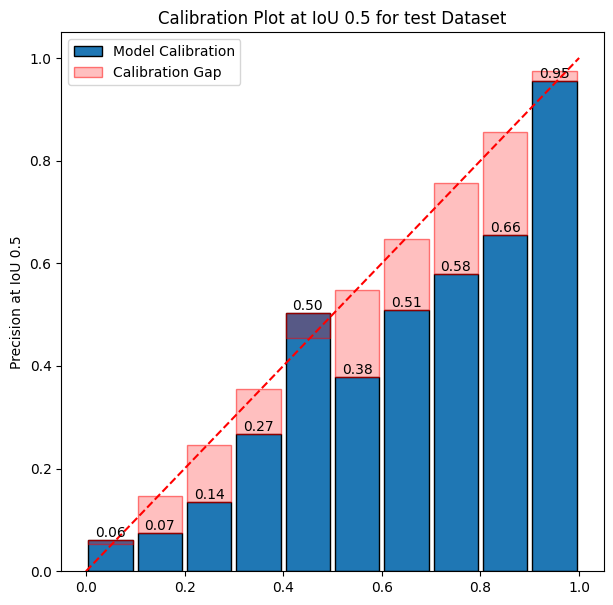

Calibration Error at IoU 0.5: 0.07
Plotting calibration curve for ensemble model 1


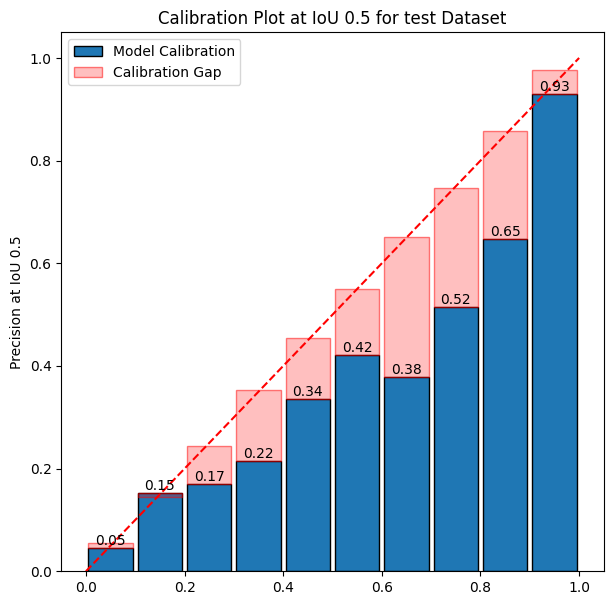

Calibration Error at IoU 0.5: 0.09
Plotting calibration curve for ensemble model 2


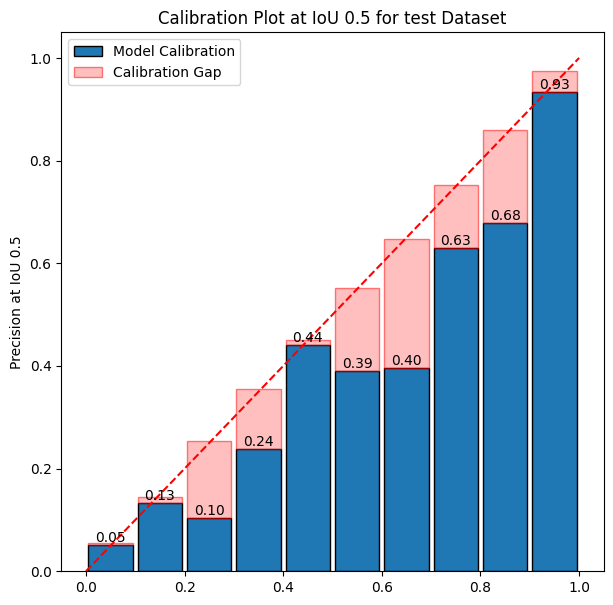

Calibration Error at IoU 0.5: 0.08
Plotting calibration curve for ensemble model 3


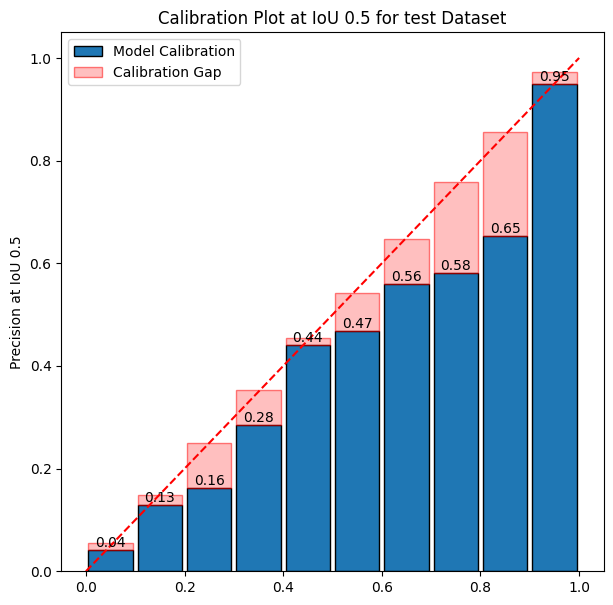

Calibration Error at IoU 0.5: 0.06
Plotting calibration curve for ensemble model 4


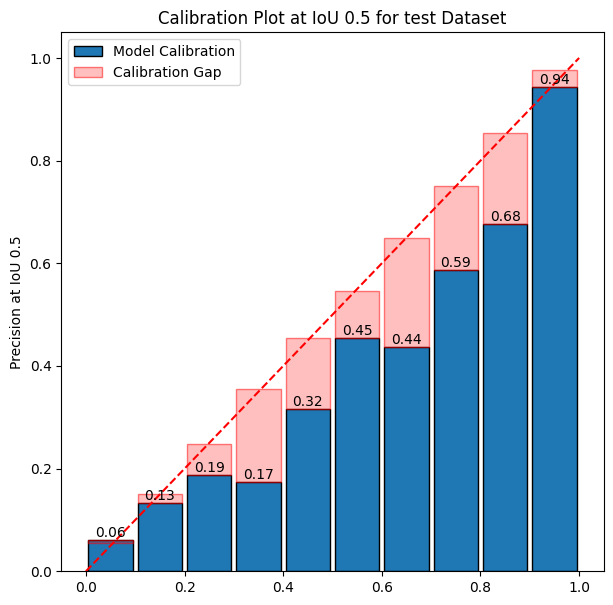

Calibration Error at IoU 0.5: 0.08
ensemble models [0.07351714705600211, 0.09497033341165836, 0.07874090697789098, 0.05527030724910653, 0.08306697385916895] mean: 0.07711313371076539, std: 0.01301551095681505


In [10]:
# plot the calibration error for the ensamble predictions
calibration_errors_multi = []
for i, matched_preds in matched_pred_ensamble.items():
    print(f"Plotting calibration curve for ensemble model {i}")
    ce = plot_calibration(matched_preds, dataset="test", iou=0.5, bins_extremes=bins_extremes, labels=labels)
    calibration_errors_multi.append(ce)

print("ensemble models", calibration_errors_multi, f"mean: {np.mean(calibration_errors_multi)}, std: {np.std(calibration_errors_multi)}")

Model performances

In [11]:
# compute and show model MAP
metrics_multi = pd.DataFrame(columns=["#Models", "MAP", "Calibration Error"])
for i, preds in predictions_ensemble.items():
    metric_model = compute_map(preds, test_dataset)
    metrics_multi.loc[len(metrics_multi)] = {"#Models": i+1, "MAP": metric_model["map"].item(), "Calibration Error": calibration_errors_multi[i]}
display(metrics_multi)

/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028
/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, af

,#Models,MAP,Calibration Error
0,1,0.467323,0.073517
1,2,0.462889,0.094970
2,3,0.463826,0.078741
3,4,0.467362,0.055270
4,5,0.460282,0.083067


# Esnamble of for models trained on both annotators

In [12]:
predictions_ensemble_all = {}
matched_pred_ensamble_all = {}
for i in range(len(best_10_all)):
    predictions = {}
    for j in range(i + 1):
        predictions[j] = predictions_all[i]
    predictions_ensemble_all[i] = ensemble_merge_predictions(predictions, 0.5)
    matched_pred_ensamble_all[i] = match_predictions(predictions_ensemble_all[i], test_dataset, 0.5)

100%|██████████| 20/20 [00:00<00:00, 38.08it/s]
20it [00:02,  7.62it/s]
100%|██████████| 20/20 [00:02<00:00,  7.20it/s]
20it [00:02,  7.92it/s]
100%|██████████| 20/20 [00:08<00:00,  2.29it/s]
20it [00:03,  6.40it/s]
100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
20it [00:03,  6.61it/s]
100%|██████████| 20/20 [00:36<00:00,  1.83s/it]
20it [00:02,  6.95it/s]
100%|██████████| 20/20 [00:55<00:00,  2.76s/it]
20it [00:03,  6.20it/s]
100%|██████████| 20/20 [01:22<00:00,  4.12s/it]
20it [00:03,  5.72it/s]
100%|██████████| 20/20 [02:13<00:00,  6.66s/it]
20it [00:03,  5.85it/s]
100%|██████████| 20/20 [02:43<00:00,  8.15s/it]
20it [00:03,  6.31it/s]
100%|██████████| 20/20 [04:13<00:00, 12.68s/it]
20it [00:03,  5.61it/s]


Plotting calibration curve for ensemble model 0


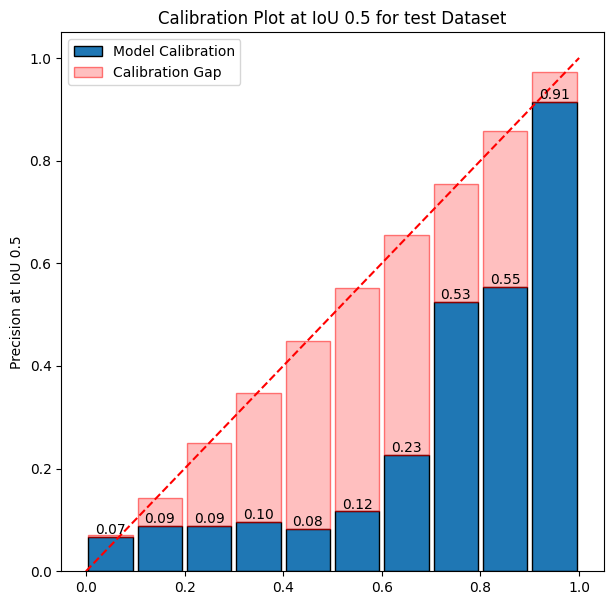

Calibration Error at IoU 0.5: 0.17
Plotting calibration curve for ensemble model 1


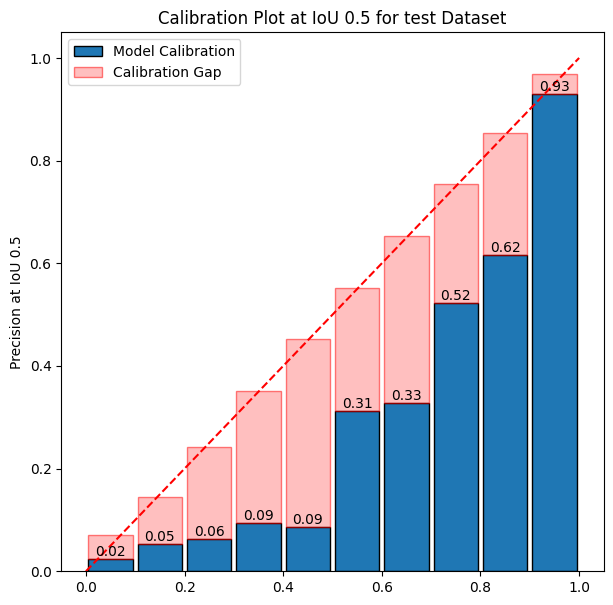

Calibration Error at IoU 0.5: 0.15
Plotting calibration curve for ensemble model 2


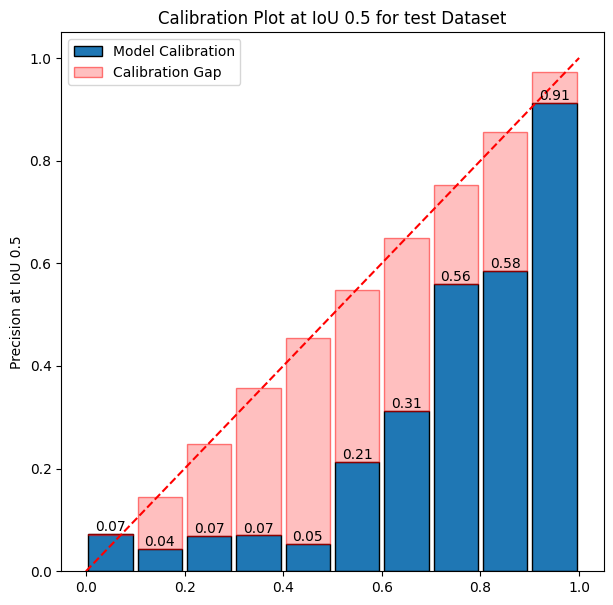

Calibration Error at IoU 0.5: 0.16
Plotting calibration curve for ensemble model 3


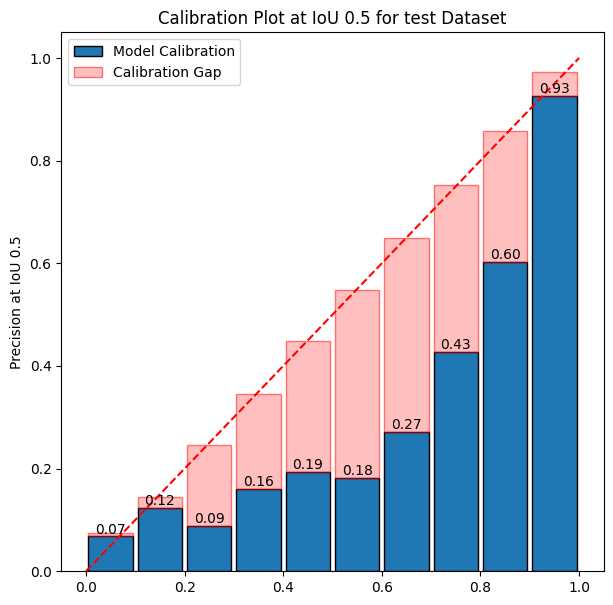

Calibration Error at IoU 0.5: 0.16
Plotting calibration curve for ensemble model 4


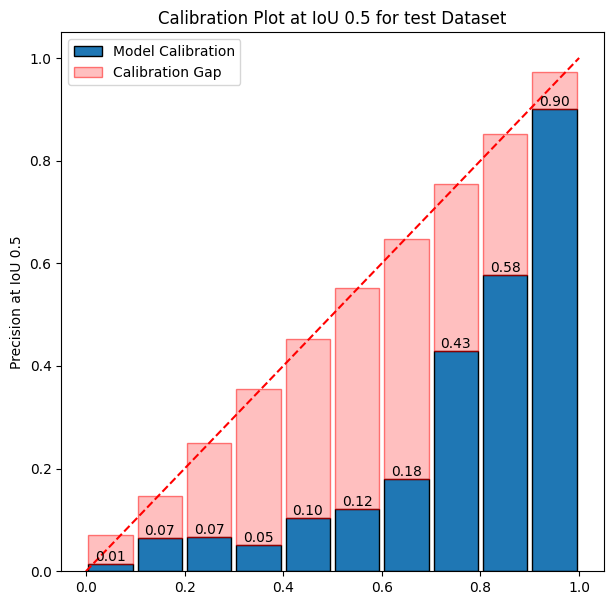

Calibration Error at IoU 0.5: 0.18
Plotting calibration curve for ensemble model 5


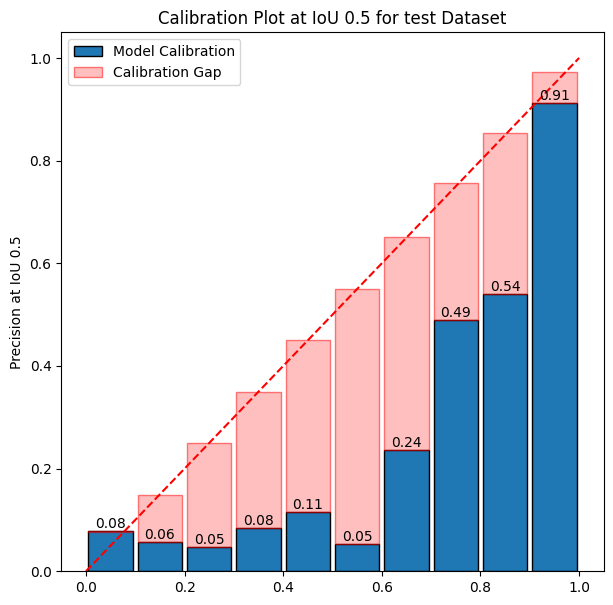

Calibration Error at IoU 0.5: 0.18
Plotting calibration curve for ensemble model 6


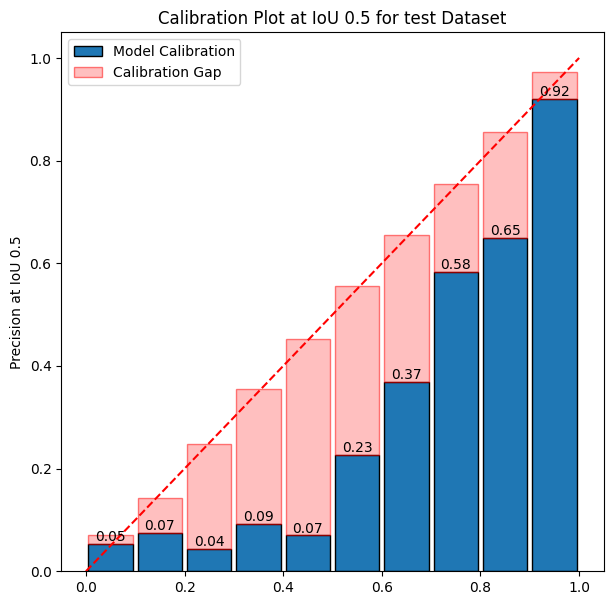

Calibration Error at IoU 0.5: 0.14
Plotting calibration curve for ensemble model 7


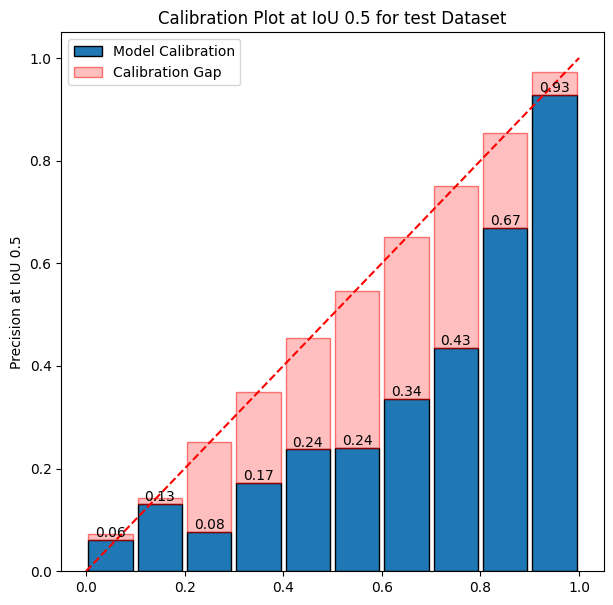

Calibration Error at IoU 0.5: 0.14
Plotting calibration curve for ensemble model 8


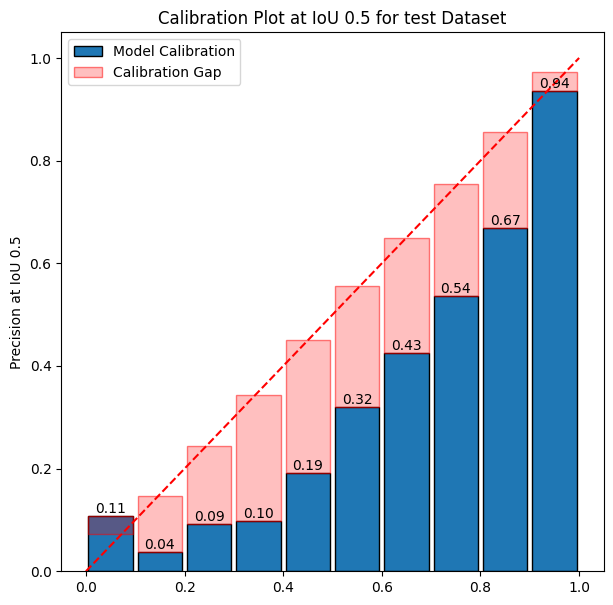

Calibration Error at IoU 0.5: 0.12
Plotting calibration curve for ensemble model 9


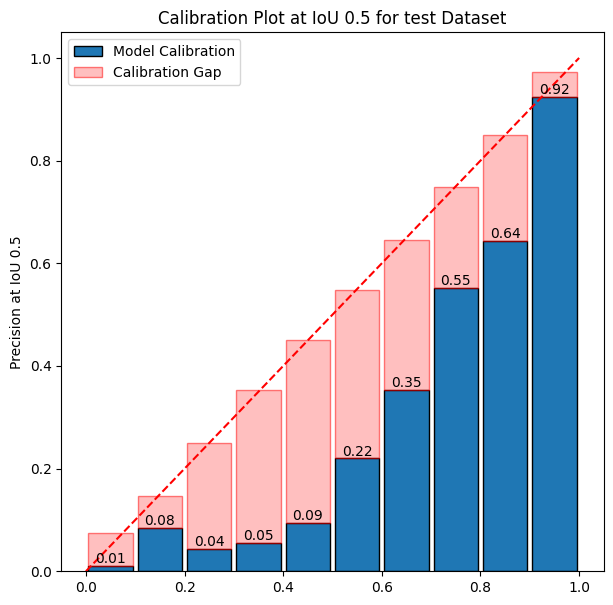

Calibration Error at IoU 0.5: 0.14
ensemble models [0.16919496329339506, 0.14698365967364577, 0.15932949925165527, 0.15818786539643426, 0.18355191220893727, 0.17515405394946662, 0.1395586958287797, 0.13664054044910204, 0.12186678095107566, 0.14360052487714497] mean: 0.15340684958796363, std: 0.018149225633193242


In [13]:
# plot the calibration error for the ensamble predictions
calibration_errors_ensamble_all = []
for i, matched_preds in matched_pred_ensamble_all.items():
    print(f"Plotting calibration curve for ensemble model {i}")
    ce = plot_calibration(matched_preds, dataset="test", iou=0.5, bins_extremes=bins_extremes, labels=labels)
    calibration_errors_ensamble_all.append(ce)

print("ensemble models", calibration_errors_ensamble_all, f"mean: {np.mean(calibration_errors_ensamble_all)}, std: {np.std(calibration_errors_ensamble_all)}")

In [14]:
# compute and show model MAP
metrics_all = pd.DataFrame(columns=["#Models", "MAP", "Calibration Error"])
for i, preds in predictions_ensemble_all.items():
    metric_model = compute_map(preds, test_dataset)
    metrics_all.loc[len(metrics_all)] = {"#Models": i+1, "MAP": metric_model["map"].item(), "Calibration Error": calibration_errors_all[i]}
display(metrics_all)

/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028
/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, af

,#Models,MAP,Calibration Error
0,1,0.468226,0.169195
1,2,0.464051,0.146984
2,3,0.459509,0.159329
3,4,0.442660,0.158188
4,5,0.467344,0.183552
5,6,0.465047,0.175154
6,7,0.465424,0.139559
7,8,0.447214,0.136641
8,9,0.458441,0.121867
9,10,0.463775,0.143601


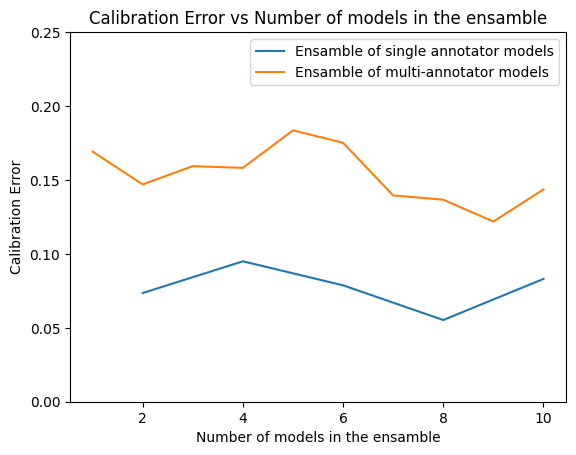

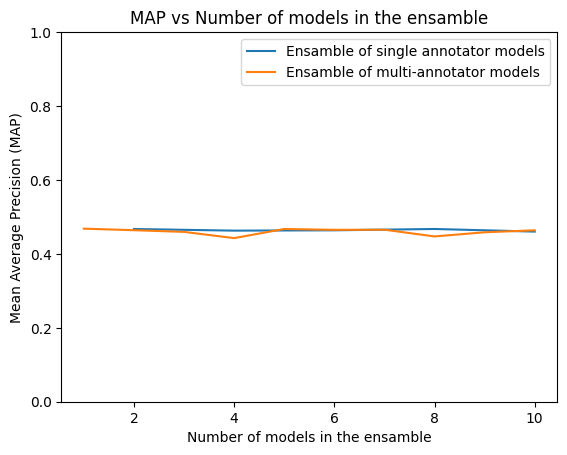

In [15]:
# plot the calibration error for differnt number of models in the ensamble
x1 = np.linspace(2, 2*len(calibration_errors_multi), len(calibration_errors_multi))
x2 = np.linspace(1, len(calibration_errors_ensamble_all), len(calibration_errors_ensamble_all))

plt.plot(x1, calibration_errors_multi, label="Ensamble of single annotator models")
plt.plot(x2, calibration_errors_ensamble_all, label="Ensamble of multi-annotator models")
plt.xlabel("Number of models in the ensamble")
plt.ylabel("Calibration Error")
plt.legend()
plt.title("Calibration Error vs Number of models in the ensamble")
plt.ylim(0, 0.25)
# position the legend in the upper right corner
plt.legend(loc="upper right")
plt.show()#!/usr/bin/env python3

# plot the map for differnt number of models in the ensamble
x1 = np.linspace(2, 2*len(metrics_multi), len(metrics_multi))
x2 = np.linspace(1, len(metrics_all), len(metrics_all))

plt.plot(x1, metrics_multi["MAP"], label="Ensamble of single annotator models")
plt.plot(x2, metrics_all["MAP"], label="Ensamble of multi-annotator models")
plt.xlabel("Number of models in the ensamble")
plt.ylabel("Mean Average Precision (MAP)")
plt.legend()
plt.title("MAP vs Number of models in the ensamble")
plt.ylim(0, 1)
# position the legend in the upper right corner
plt.legend(loc="upper right")
plt.show()

## error bars on the calibration error

We want to show the error bars on the calibration error for different number of models in the ensamble. To do so we bootstrap the test set and compute the calibration error for each bootstrap sample. We then compute the mean and standard deviation of the calibration error across the bootstrap samples.

In [28]:
def bootstrap(matched_predictions: pd.DataFrame, n_bootstrap: int = 100):
    image_ids = matched_predictions["image_id"].unique()
    n_samples = len(image_ids)
    matched_predictions_bootstrap = {}
    for b in range(n_bootstrap):
        # sample with replacement
        indices = np.random.choice(image_ids, n_samples, replace=True)
        temp = pd.DataFrame(columns=matched_predictions.columns)
        temp = matched_predictions[matched_predictions["image_id"] == indices[0]]
        for id in indices[1:]:
            temp = pd.concat([temp, matched_predictions[matched_predictions["image_id"] == id]], ignore_index=True)
        matched_predictions_bootstrap[b] = temp
    return matched_predictions_bootstrap

### Ensamble of single rater models

In [36]:
calibration_errors_bootstrap_single = {}
for i, matched_preds in matched_pred_ensamble.items():
    print(f"Bootstrapping ensemble model {i}")
    matched_preds_bootstrap = bootstrap(matched_preds, n_bootstrap=100)
    calibration_errors = []
    for b, matched in matched_preds_bootstrap.items():
        bins = bin_predictions(matched, bins_extremes=bins_extremes, labels=labels)
        ce = compute_calibration_error(bins)
        calibration_errors.append(ce)
    mean_ce = np.mean(calibration_errors)
    std_ce = np.std(calibration_errors)
    print(f"Ensemble size: {i+1}, Calibration Error: {mean_ce:.3f} ± {std_ce:.3f}")
    calibration_errors_bootstrap_single[i] = calibration_errors

Bootstrapping ensemble model 0
Ensemble size: 1, Calibration Error: 0.079 ± 0.019
Bootstrapping ensemble model 1
Ensemble size: 2, Calibration Error: 0.098 ± 0.023
Bootstrapping ensemble model 2
Ensemble size: 3, Calibration Error: 0.091 ± 0.022
Bootstrapping ensemble model 3
Ensemble size: 4, Calibration Error: 0.064 ± 0.019
Bootstrapping ensemble model 4
Ensemble size: 5, Calibration Error: 0.093 ± 0.026


### Ensemble of multi rater models

In [35]:
calibration_errors_bootstrap_all = {}
for i, matched_preds in matched_pred_ensamble_all.items():
    print(f"Bootstrapping ensemble model {i}")
    matched_preds_bootstrap = bootstrap(matched_preds, n_bootstrap=100)
    calibration_errors = []
    for b, matched in matched_preds_bootstrap.items():
        bins = bin_predictions(matched, bins_extremes=bins_extremes, labels=labels)
        ce = compute_calibration_error(bins)
        calibration_errors.append(ce)
    mean_ce = np.mean(calibration_errors)
    std_ce = np.std(calibration_errors)
    print(f"Ensemble size: {i+1}, Calibration Error: {mean_ce:.3f} ± {std_ce:.3f}")
    calibration_errors_bootstrap_all[i] = calibration_errors

Bootstrapping ensemble model 0
Ensemble size: 1, Calibration Error: 0.166 ± 0.024
Bootstrapping ensemble model 1
Ensemble size: 2, Calibration Error: 0.149 ± 0.031
Bootstrapping ensemble model 2
Ensemble size: 3, Calibration Error: 0.159 ± 0.028
Bootstrapping ensemble model 3
Ensemble size: 4, Calibration Error: 0.159 ± 0.028
Bootstrapping ensemble model 4
Ensemble size: 5, Calibration Error: 0.180 ± 0.026
Bootstrapping ensemble model 5
Ensemble size: 6, Calibration Error: 0.180 ± 0.026
Bootstrapping ensemble model 6
Ensemble size: 7, Calibration Error: 0.142 ± 0.026
Bootstrapping ensemble model 7
Ensemble size: 8, Calibration Error: 0.143 ± 0.029
Bootstrapping ensemble model 8
Ensemble size: 9, Calibration Error: 0.124 ± 0.025
Bootstrapping ensemble model 9
Ensemble size: 10, Calibration Error: 0.146 ± 0.024


### Plot the CE with errorbars

In the first plot the error bars are the std, in the second plot the error bars are the 95% confidence interval

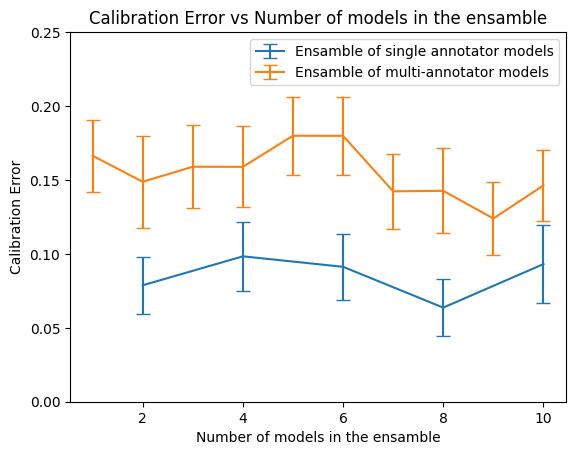

In [37]:
# plot the calibration error with error bars for differnt number of models in the ensamble
x1 = np.linspace(2, 2*len(calibration_errors_bootstrap_single), len(calibration_errors_bootstrap_single))
y1 = [np.mean(calibration_errors_bootstrap_single[i]) for i in range(len(calibration_errors_bootstrap_single))]
y1_err = [np.std(calibration_errors_bootstrap_single[i]) for i in range(len(calibration_errors_bootstrap_single))]
x2 = np.linspace(1, len(calibration_errors_bootstrap_all), len(calibration_errors_bootstrap_all))
y2 = [np.mean(calibration_errors_bootstrap_all[i]) for i in range(len(calibration_errors_bootstrap_all))]
y2_err = [np.std(calibration_errors_bootstrap_all[i]) for i in range(len(calibration_errors_bootstrap_all))]

plt.errorbar(x1, y1, yerr=y1_err, label="Ensamble of single annotator models", capsize=5)
plt.errorbar(x2, y2, yerr=y2_err, label="Ensamble of multi-annotator models", capsize=5)
plt.xlabel("Number of models in the ensamble")
plt.ylabel("Calibration Error")
plt.title("Calibration Error vs Number of models in the ensamble")
plt.ylim(0, 0.25)
# position the legend in the upper right corner
plt.legend(loc="upper right")
plt.show()

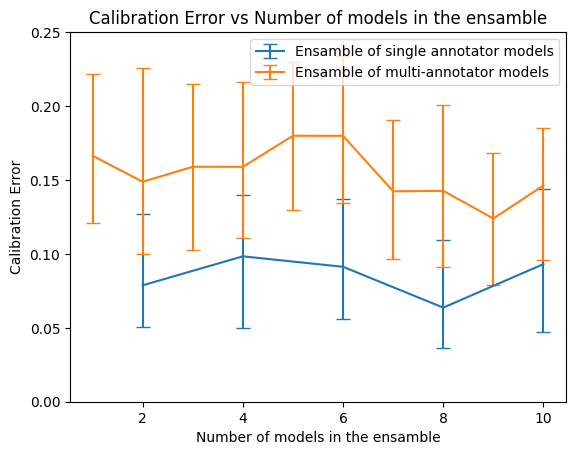

In [38]:
x1 = np.linspace(2, 2*len(calibration_errors_bootstrap_single), len(calibration_errors_bootstrap_single))
y1 = [np.mean(calibration_errors_bootstrap_single[i]) for i in range(len(calibration_errors_bootstrap_single))]
y1_err_lower = [np.percentile(calibration_errors_bootstrap_single[i], 2.5) for i in range(len(calibration_errors_bootstrap_single))]
y1_err_upper = [np.percentile(calibration_errors_bootstrap_single[i], 97.5) for i in range(len(calibration_errors_bootstrap_single))]
x2 = np.linspace(1, len(calibration_errors_bootstrap_all), len(calibration_errors_bootstrap_all))
y2 = [np.mean(calibration_errors_bootstrap_all[i]) for i in range(len(calibration_errors_bootstrap_all))]
y2_err_lower = [np.percentile(calibration_errors_bootstrap_all[i], 2.5) for i in range(len(calibration_errors_bootstrap_all))]
y2_err_upper = [np.percentile(calibration_errors_bootstrap_all[i], 97.5) for i in range(len(calibration_errors_bootstrap_all))]\

plt.errorbar(x1, y1, yerr=[np.array(y1) - np.array(y1_err_lower), np.array(y1_err_upper) - np.array(y1)], label="Ensamble of single annotator models", capsize=5)
plt.errorbar(x2, y2, yerr=[np.array(y2) - np.array(y2_err_lower), np.array(y2_err_upper) - np.array(y2)], label="Ensamble of multi-annotator models", capsize=5)
plt.xlabel("Number of models in the ensamble")
plt.ylabel("Calibration Error")
plt.title("Calibration Error vs Number of models in the ensamble")
plt.ylim(0, 0.25)
# position the legend in the upper right corner
plt.legend(loc="upper right")
plt.show()

### Comapare the results predicted by the model with GT uncertainty

GT uncertainty can be defined as the rater agreement level, we look at which model (trained on both, vs ensamble of 2 models trained on each rater) is better at guessing the gt uncertainty

In [17]:
from utils import *

import os
import sys
sys.path.append(os.path.join(os.getcwd()))

import pickle
from torch import tensor
import torch
from torch.utils.data import DataLoader


from src.model.dataset import MaskRCNNDataset
from src.model.model import maskRCNNModel
from src.model.engine import FitterMaskRCNN

In [18]:
def match_boxes(boxes_1, boxes_2, iou_threshold):
    iou_matrix = compute_iou_matrix(boxes_1, boxes_2)
    row_ind, col_ind = instance_matcher(iou_matrix, iou_threshold=iou_threshold)
    return row_ind, col_ind

def gt_confidence(preds, ground_truth, model, iou_threshold=0.5):
    scores_1 = {}
    scores_05 = {}
    scores_0 = {}
    print(len(ground_truth))
    for img_id,(pred, gt) in tqdm(enumerate(zip(preds, ground_truth))):
        # match the pred to the gt with score 1
        gt_boxes_1 = gt["boxes"][np.where(gt["scores"] == 1)]
        id_gt_1, id_pred_1 = match_boxes(gt_boxes_1, pred["boxes"].cpu().numpy(), iou_threshold=0.5)
        gt_boxes_05 = gt["boxes"][np.where(gt["scores"] == 0.5)]
        id_gt_05, id_pred_05 = match_boxes(gt_boxes_05, pred["boxes"].cpu().numpy(), iou_threshold=0.5)
        scores_1[img_id] = []
        scores_05[img_id] = []
        scores_0[img_id] = []
        for i in range(len(pred["boxes"])):
            if i in id_pred_1:
                scores_1[img_id].append(pred["scores"][i].item())
            elif i in id_pred_05:
                scores_05[img_id].append(pred["scores"][i].item())
            else:
                scores_0[img_id].append(pred["scores"][i].item())

    fig, ax = plt.subplots(1, len(ground_truth), figsize=(5*len(ground_truth), 5))
    print(len(ground_truth))
    for i in range(len(ground_truth)):
        ax[i].boxplot([scores_1[i], scores_05[i], scores_0[i]], tick_labels=["1.0", "0.5", "0"])
        ax[i].set_title(f"Image {i}")
        ax[i].set_xlabel("Ground Truth confidence")
        ax[i].set_ylabel("Predicted confidence")
        ax[i].legend()
    plt.show()

    # make a summary plot
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.boxplot([np.concatenate(list(scores_1.values())), np.concatenate(list(scores_05.values())), np.concatenate(list(scores_0.values()))], tick_labels=["1.0", "0.5", "0"])
    ax.set_title(f"Confidence Distribution for {model}")
    ax.set_xlabel("Rater Agreement")
    ax.set_ylabel("Predicted confidence")
    ax.legend()
    plt.show()

We test on the models trained ona single annotator

/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
100%|██████████| 20/20 [00:03<00:00,  5.81it/s]


two models trained on sigle annotators
20


20it [00:07,  2.55it/s]
/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_13532/3427595624.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()
/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_13532/3427595624.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()
/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_13532/3427595624.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()
/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_13532/3427595624.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whos

20


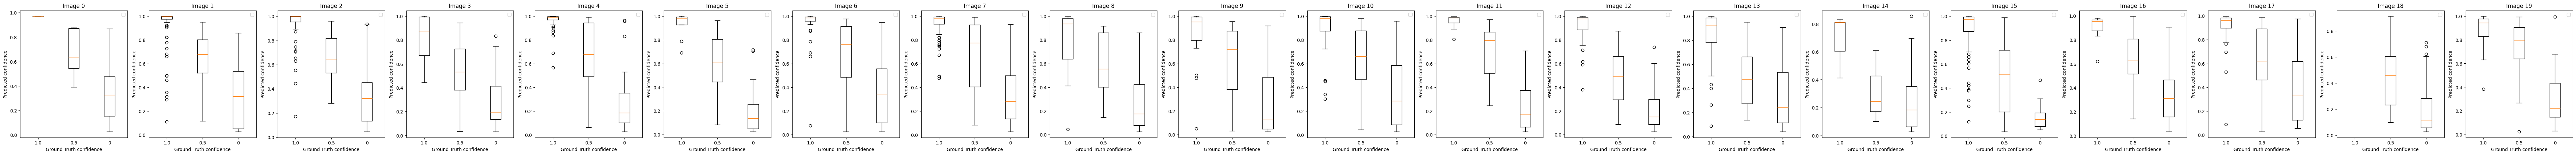

/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_13532/3427595624.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


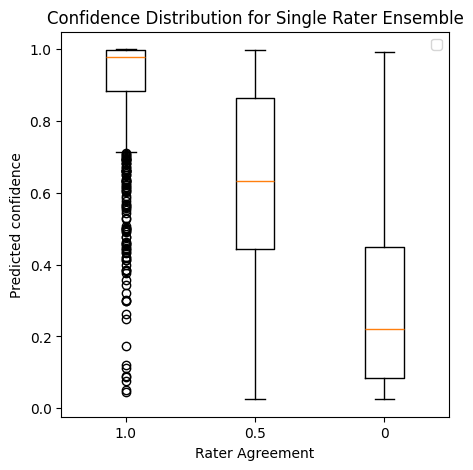

model trained on both annotators
20


20it [00:07,  2.61it/s]
/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_13532/3427595624.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()
/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_13532/3427595624.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()
/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_13532/3427595624.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()
/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_13532/3427595624.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whos

20


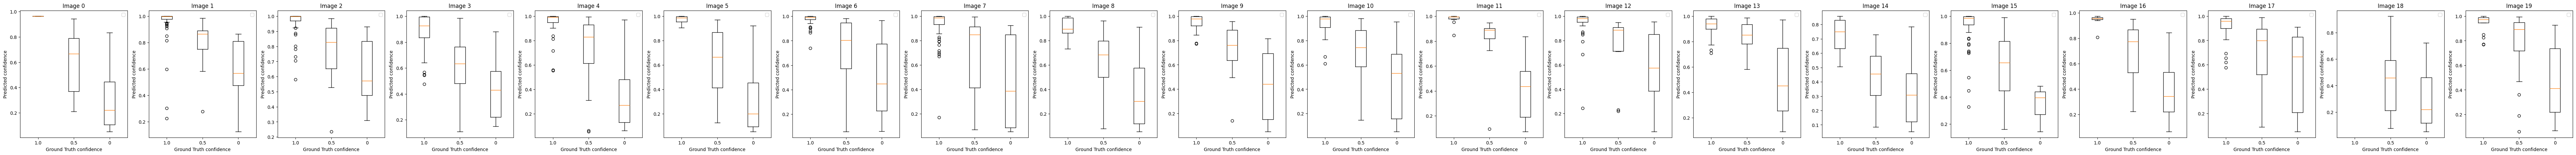

/var/folders/74/pjwdjs550d91v4lc_1_rqm6r0000gn/T/ipykernel_13532/3427595624.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


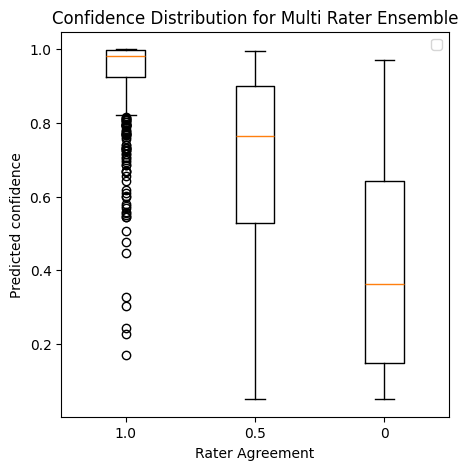

In [19]:
# compute the GT uncertainty

test_dataset_multi_path = "../dataset/test_multirater"
test_dataset_multi_1 = MaskRCNNDataset(dataset_path=test_dataset_multi_path, datatype="eval", data_augmentation=None, annotator=1)
test_dataset_multi_2 = MaskRCNNDataset(dataset_path=test_dataset_multi_path, datatype="eval", data_augmentation=None, annotator=2)


n = 4
matches = match_labels(test_dataset_multi_1, test_dataset_multi_2, iou_threshold=0.5)
print("two models trained on sigle annotators")
gt_confidence(predictions_ensemble[n], matches, model="Single Rater Ensemble", iou_threshold=0.5)
print("model trained on both annotators")
gt_confidence(predictions_ensemble_all[n*2], matches, model="Multi Rater Ensemble", iou_threshold=0.5)
